<a href="https://colab.research.google.com/github/Lewis34cs/corona_audio/blob/main/covid_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project

#### COVID-19 Exploration in statistics and diagnosis via imaging and audio

>Flow of project:
- go into diagnosing COVID-19 using x-rays
- explain how while this is useful, it requires the patient to actually come in and get an x-ray, which can bring risk of infection to those in the building where x-ray imaging is done
- talk about coughing audio, how we can create spectrogram images from it to train neural networks to try and achieve a high recall/auc.

In [1]:
# We must run this in order for colab to be able to access our google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Allows us to see the type of GPU we are given

# Because we have Google Pro, we are given a better GPU to work with, which means
# we are able to do everything at a faster pace than those with no Google Pro subscription.
# We can verify this by taking a look at the GPU we are given below.

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jan 16 22:01:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Importing Libraries

In [3]:
#Setting seeds first in order to achieve better consistency in scoring
import numpy as np
import tensorflow as tf

np.random.seed(321)
tf.random.set_seed(321)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os, sys, glob, shutil
import datetime as dt

In [5]:
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
import time
from IPython.display import Image, display
from PIL import Image as Im
import cv2
import shutil
from google.colab import files

# tensorflow libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.applications import VGG19, InceptionV3, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_addons as tfa

In [6]:
import librosa
import librosa.display as ldp
import IPython.display as ipd

In [7]:
# installing other libraries
!pip install split-folders
!pip install split-folders tqdm
!pip install pydub
!pip install ffmpeg-python
!pip install zip_files

In [8]:
import splitfolders
from tqdm import tqdm
from pydub import AudioSegment
from pydub.playback import play
import ffmpeg

In [9]:
plt.style.use('dark_background')

# PART 1

## Obtaining Exploratory Data

In [10]:
# Viewing where we are in the directory
os.path.abspath(os.curdir)

'/content'

In [11]:
# Changing to the root directory
%cd ~
%cd ..

/root
/


In [12]:
# Confirming that we are in the root directory
os.path.abspath(os.curdir)

'/'

In [13]:
def folder_contents(source_folder=os.path.abspath(os.curdir)): # '/content/drive/My Drive'):
    """
    Definition:
    Displays the contents within a source folder.

    Parameter:
    source_folder: default = os.path.abspath(os.curdir) -- when a folder is set to
    this parameter, the function will display everything within that folder.

    Returns:
    Prints the address of the source_folder and displays the contents within.
    """

    print(f"Contents of {source_folder}:\n")
    display(sorted(os.listdir(source_folder)))

>Our first dataset we will be using is the 'COVID-19_Case_Surveillance_Public_Use_Data.csv' within our drive. This dataset was retrieved from the Centers for Disease Control and Prevention.

Link to the data: https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf

Note that there is another version of this dataset that contains more information about each patient, however that particular data is a restricted access dataset. If I used the restricted access dataset, I would not be able to explore and interpret any findings on Google Colab, and I would be required to protect that dataset in order to safeguard those who may be identifiable within it. Therefore, I will be sticking with the public access dataset for this project.

In [14]:
folder_contents('/content/drive/My Drive')

Contents of /content/drive/My Drive:



['COVID-19 Classification.gslides',
 'COVID-19_Case_Surveillance_Public_Use_Data.csv',
 'Colab Notebooks',
 'Copy of COVID-19 by Slidesgo.gslides',
 'Getting started.pdf',
 'archive.zip',
 'data_upload_v2.zip',
 'gdrive',
 'master_dataset.csv',
 'novel_covid_data.zip',
 'presentations',
 'public_dataset.zip',
 'virufy_data-main.zip']

>The dataset we will begin exploring will be the 'COVID-19_Case_Surveillance_Public_Use_Data.csv' file.

## Scrubbing and Exploring

### Dataset from CDC

*Definition of Columns*:

- **cdc_report_dt**: Initial case report date to CDC
- **pos_spec_dt**: Date of first positive specimen collection
- **onset_dt**: Symptom onset date, if symptomatic
- **current_status**: Case Status: Laboratory-confirmed case; Probable case
- **sex**: Male, Female, Unknown, Other
- **age_group**: Age Group: 0 - 9 Years; 10 - 19 Years; 20 - 39 Years; 40 - 49 Years; 50 - 59 Years; 60 - 69 Years; 70 - 79 Years; 80 + Years
- **Race and ethnicity (combined)**: Race and ethnicity (combined): Hispanic/Latino; American Indian / Alaska Native, Non-Hispanic; Asian, Non-Hispanic; Black, Non-Hispanic; Native Hawaiian / Other Pacific Islander, Non-Hispanic; White, Non-Hispanic; Multiple/Other, Non-Hispanic
- **hosp_yn**: Hospitalization status
- **icu_yn**: ICU admission status
- **death_yn**: death status
- **medcond_yn**: Presence of underlying comorbidity or disease

>This dataset that we gathered has been supressed in order to prevent anyone within the dataset to be identified.

According to the CDC, "To prevent release of data that could be used to identify people, data cells are suppressed for low frequency (<5) records and indirect identifiers (date of first positive specimen). Suppression includes uncommon combinations of demographic characteristics (sex, age group, race/ethnicity). Suppressed values are re-coded to the NA answer option."

>We should also note some of the values within each column; particularly the 'Missing' and 'Unknown' values. For these values, the CDC gives these reasons:

"Questions that have been left unanswered (blank) on the case report form are re-classified to a Missing value, if applicable to the question. For example, in the question “Was the individual hospitalized?,” where the possible answer choices include “Yes,” “No,” or “Unknown,” the missing value is re-coded to Missing if the respondent did not answer the question."

Because of this reasoning, we will replace all "Missing" values with "Unknown" values in our columns.

In [15]:
cdc_data = pd.read_csv('/content/drive/My Drive/COVID-19_Case_Surveillance_Public_Use_Data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
cdc_data.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/11/10,2020/11/10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No
1,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
2,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
3,2020/11/14,2020/11/10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,No,Missing
4,2020/11/13,2020/11/10,2020/11/10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes


In [17]:
# renaming column for easier use
cdc_data.rename(columns={'Race and ethnicity (combined)': 'race_ethnicity'}, inplace=True)

In [18]:
cdc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405079 entries, 0 to 8405078
Data columns (total 11 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   cdc_report_dt   object
 1   pos_spec_dt     object
 2   onset_dt        object
 3   current_status  object
 4   sex             object
 5   age_group       object
 6   race_ethnicity  object
 7   hosp_yn         object
 8   icu_yn          object
 9   death_yn        object
 10  medcond_yn      object
dtypes: object(11)
memory usage: 705.4+ MB


In [19]:
cdc_data.isna().sum()

cdc_report_dt           0
pos_spec_dt       5534290
onset_dt          4009122
current_status          0
sex                    18
age_group              89
race_ethnicity          7
hosp_yn                 0
icu_yn                  0
death_yn                0
medcond_yn              0
dtype: int64

In [20]:
print("Percentage of null values for each column in cdc_data")
print('-----'*5)
for col in cdc_data.columns:
  print(f"{col} : {round(cdc_data[col].isna().sum()/len(cdc_data), 3)}")

Percentage of null values for each column in cdc_data
-------------------------
cdc_report_dt : 0.0
pos_spec_dt : 0.658
onset_dt : 0.477
current_status : 0.0
sex : 0.0
age_group : 0.0
race_ethnicity : 0.0
hosp_yn : 0.0
icu_yn : 0.0
death_yn : 0.0
medcond_yn : 0.0


>We see that for the pos_spec_dt (date of first positive specimen) and the onset_dt (symptom onset date, if symptomatic) both contain a large number of null values. These null values could be important, they may represent people who did not have a positive specimen (for pos_spec_dt) and those who may be asymptomatic (symptom_onset_date)

#### Converting certain columns into a datetime object

In [21]:
cdc_data.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/11/10,2020/11/10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No
1,2020/11/14,2020/11/10,2020/11/10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
2,2020/11/19,2020/11/10,2020/11/09,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
3,2020/11/14,2020/11/10,NaN,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,No,Missing
4,2020/11/13,2020/11/10,2020/11/10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes


In [22]:
cdc_data['cdc_report_dt'] = pd.to_datetime(cdc_data['cdc_report_dt'])
# Because there are null values in the bottom two, we must set the param
# errors = 'coerce' in order to avoid any raised exceptions
cdc_data['pos_spec_dt'] = pd.to_datetime(cdc_data['pos_spec_dt'], errors='coerce')
cdc_data['onset_dt'] = pd.to_datetime(cdc_data['onset_dt'], errors='coerce')

In [23]:
cdc_data.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-11-10,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No
1,2020-11-14,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
2,2020-11-19,2020-11-10,2020-11-09,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,No
3,2020-11-14,2020-11-10,NaT,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",Missing,Missing,No,Missing
4,2020-11-13,2020-11-10,2020-11-10,Laboratory-confirmed case,Male,10 - 19 Years,"Black, Non-Hispanic",No,No,No,Yes


#### Inspecting 'race_ethnicity' column

In [24]:
cdc_data['race_ethnicity'].value_counts()

Unknown                                                 2781176
White, Non-Hispanic                                     2599410
Hispanic/Latino                                         1195739
Black, Non-Hispanic                                      736584
Missing                                                  601519
Multiple/Other, Non-Hispanic                             270509
Asian, Non-Hispanic                                      143080
American Indian/Alaska Native, Non-Hispanic               59842
Native Hawaiian/Other Pacific Islander, Non-Hispanic      17213
Name: race_ethnicity, dtype: int64

In [25]:
cdc_data['race_ethnicity'].isna().sum()

7

In [26]:
# Putting both null values and values = 'Missing' into 'Unknown column, 
# since Missing and Unknown are the same thing
cdc_data['race_ethnicity'] = cdc_data['race_ethnicity'].replace(np.nan, 'Unknown')
cdc_data['race_ethnicity'] = cdc_data['race_ethnicity'].replace('Missing', 'Unknown')

In [27]:
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=15)    # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title

# Defining constant for colab
C_DICT = {'color': 'w'}

In [28]:
def make_plot(y, data, title, figsize=(10,10)):
  fig, ax = plt.subplots(figsize=figsize)
  ax = sns.countplot(y=y, data=data)
  # Setting title and color
  ax.set_title(title)
  ax.title.set_color('white')

  # Setting x-axis ticks and label color
  ax.tick_params(axis='x', colors='white')
  ax.xaxis.label.set_color('white')

  # Setting y-axis ticks and label color
  ax.tick_params(axis='y', colors='white')
  ax.yaxis.label.set_color('white')
  plt.show()

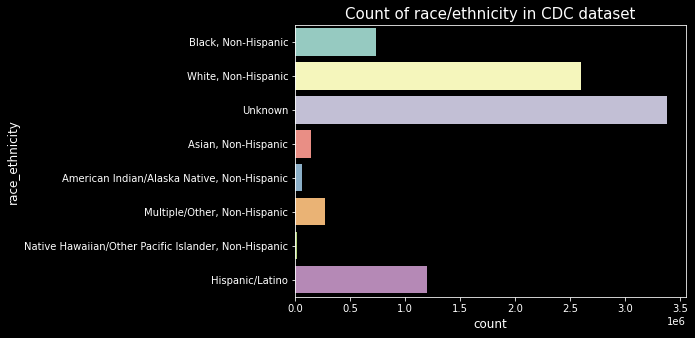

In [29]:
make_plot(y='race_ethnicity', data=cdc_data, title='Count of race/ethnicity in CDC dataset', 
          figsize=(7, 5))

> We see that the majority of the race/ethnicity for patients in this dataset are 'Unknown', with White/Non-Hispanic and Hispanic/Latino following in second and third largest categories, respectively.

#### Inspecting 'age_group' column

In [30]:
cdc_data['age_group'].value_counts()

20 - 29 Years    1635264
30 - 39 Years    1372623
40 - 49 Years    1267350
50 - 59 Years    1227493
60 - 69 Years     863260
10 - 19 Years     841450
70 - 79 Years     483689
80+ Years         382869
0 - 9 Years       299040
Unknown            31952
Name: age_group, dtype: int64

In [31]:
# There are 89 np.nan values in this column
cdc_data['age_group'].isna().sum()

89

In [32]:
# replacing np.nan values with 'Unknown'
cdc_data['age_group'] = cdc_data['age_group'].replace(np.nan, 'Unknown')

In [33]:
# gathering groups and values from age_group and putting into lists
age_group_list = cdc_data['age_group'].value_counts().index.tolist()
value_count_list = cdc_data['age_group'].value_counts().tolist()

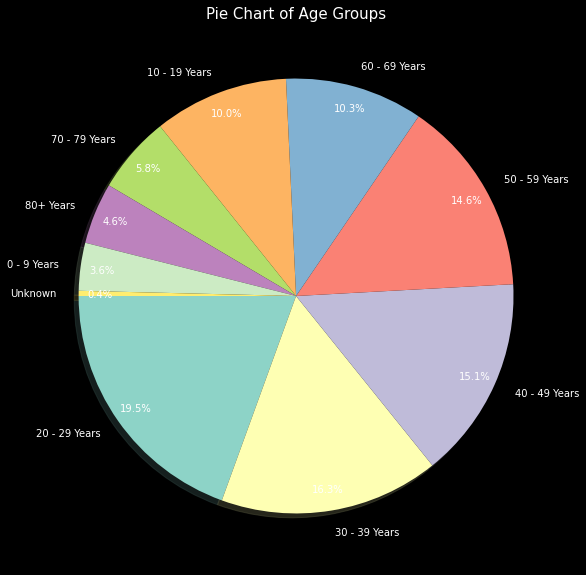

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(x=value_count_list, labels=age_group_list, 
        autopct='%1.1f%%', shadow=True, startangle=180, pctdistance=0.9, 
       textprops=C_DICT)
ax.set_title('Pie Chart of Age Groups', fontdict=C_DICT)
plt.show()

>The majority of patients (65.5%) within this dataset lie between the ages of 20-59 years old. Only around 20% of the dataset consists of patients that are older than 60 years of age. Less than 14% of the patients are 19 years old or younger. About half a percent are unknown.

#### Inspecting 'sex' column

In [35]:
cdc_data['sex'].value_counts()

Female     4340898
Male       3970591
Unknown      73845
Missing      19520
Other          207
Name: sex, dtype: int64

In [36]:
cdc_data['sex'].isna().sum()

18

In [37]:
# Putting our 'Missing' and null values into the 'Unknown' category
cdc_data['sex'] = cdc_data['sex'].replace(np.nan, 'Unknown')
cdc_data['sex'] = cdc_data['sex'].replace('Missing', 'Unknown')

In [38]:
cdc_data['sex'].value_counts()

Female     4340898
Male       3970591
Unknown      93383
Other          207
Name: sex, dtype: int64

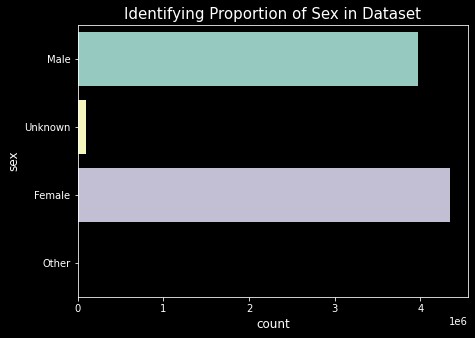

In [39]:
make_plot(y='sex', data=cdc_data, title='Identifying Proportion of Sex in Dataset', 
          figsize=(7, 5))

> The data seems to be relatively balanced in terms of the male to female ratio in our 'sex' column. However, we must also make note of the 'other' and 'unknown' categories.

#### Inspecting 'current_status' column

In [40]:
cdc_data['current_status'].value_counts()

Laboratory-confirmed case    7910118
Probable Case                 494961
Name: current_status, dtype: int64

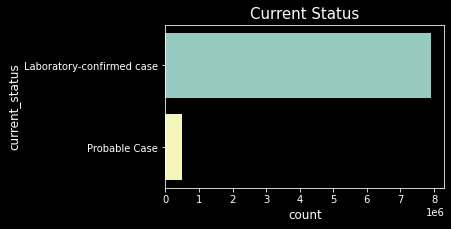

In [41]:
make_plot('current_status', cdc_data, 'Current Status', figsize=(5, 3))

>It seems that the majority of cases within our dataset were confirmed by a laboratory as having covid at the time of their testing. 

#### Inspecting 'medcond_yn' column

In [42]:
cdc_data['medcond_yn'].value_counts()

Missing    6063390
Unknown     838018
Yes         785255
No          718416
Name: medcond_yn, dtype: int64

In [43]:
cdc_data['medcond_yn'] = cdc_data['medcond_yn'].replace('Missing', 'Unknown')

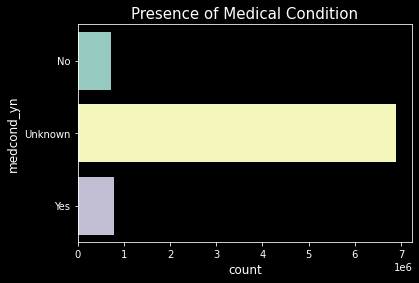

In [44]:
make_plot('medcond_yn', cdc_data, 'Presence of Medical Condition', figsize=(6,4))

>We do not know whether or not the majority of patients within our dataset have a medical condition.

#### Inspecting 'hosp_yn' column

In [45]:
cdc_data['hosp_yn'].value_counts()

No         3502556
Missing    3227302
Unknown    1136450
Yes         538771
Name: hosp_yn, dtype: int64

In [46]:
cdc_data['hosp_yn'] = cdc_data['hosp_yn'].replace('Missing', 'Unknown')

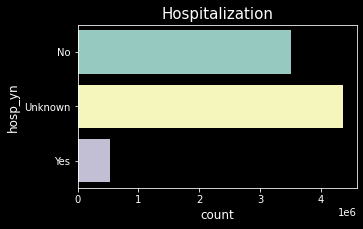

In [47]:
make_plot(y='hosp_yn', data=cdc_data, title='Hospitalization', figsize=(5, 3))

>The majority of patients (that were specified as either yes or no) seemed to not need to be admitted into the hospital because of COVID-19. We should also notice the large proportion of missing/unknown hospitalizations. This category accounts for almost half of the dataset.

#### Inspecting 'icu_yn' column

In [48]:
cdc_data['icu_yn'].value_counts()

Missing    6178281
Unknown    1286236
No          879671
Yes          60891
Name: icu_yn, dtype: int64

In [49]:
cdc_data['icu_yn'] = cdc_data['icu_yn'].replace('Missing', 'Unknown')

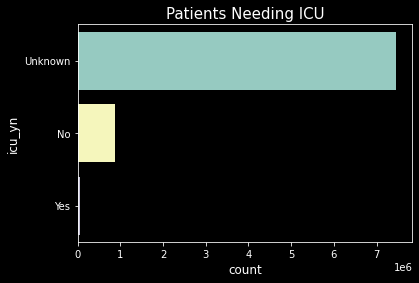

In [50]:
make_plot('icu_yn', cdc_data, 'Patients Needing ICU', figsize=(6, 4))

While there are an overwhelming amount of unknown indications as to if a patient went to the ICU, we should note that those who were confirmed going to the ICU account for about 60,000 patients within the dataset.

#### Inspecting 'death_yn' column

In [51]:
cdc_data['death_yn'].value_counts()

No         3690813
Missing    3486923
Unknown    1043766
Yes         183577
Name: death_yn, dtype: int64

In [52]:
cdc_data['death_yn'] = cdc_data['death_yn'].replace('Missing', 'Unknown')

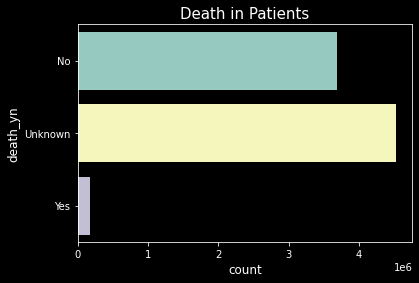

In [53]:
make_plot('death_yn', cdc_data, 'Death in Patients', figsize=(6, 4))

## Exploring patient info who died

Since we want to explore the data who is at highest risk for mortality, we will be targeting those who died in our cdc_data

In [54]:
death_df = cdc_data[cdc_data['death_yn'] == 'Yes']

In [55]:
death_df.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity,hosp_yn,icu_yn,death_yn,medcond_yn
349,2020-11-17,2020-11-10,2020-11-05,Laboratory-confirmed case,Female,10 - 19 Years,"White, Non-Hispanic",No,Unknown,Yes,No
1155,2020-11-17,2020-11-10,2020-11-05,Laboratory-confirmed case,Female,10 - 19 Years,"White, Non-Hispanic",No,Unknown,Yes,No
2956,2020-11-17,2020-11-10,2020-11-06,Laboratory-confirmed case,Male,10 - 19 Years,"White, Non-Hispanic",No,No,Yes,No
3736,2020-11-17,2020-11-10,2020-11-09,Laboratory-confirmed case,Male,10 - 19 Years,"White, Non-Hispanic",No,Unknown,Yes,No
4213,2020-11-17,2020-11-10,2020-11-08,Laboratory-confirmed case,Female,10 - 19 Years,"Black, Non-Hispanic",No,No,Yes,No


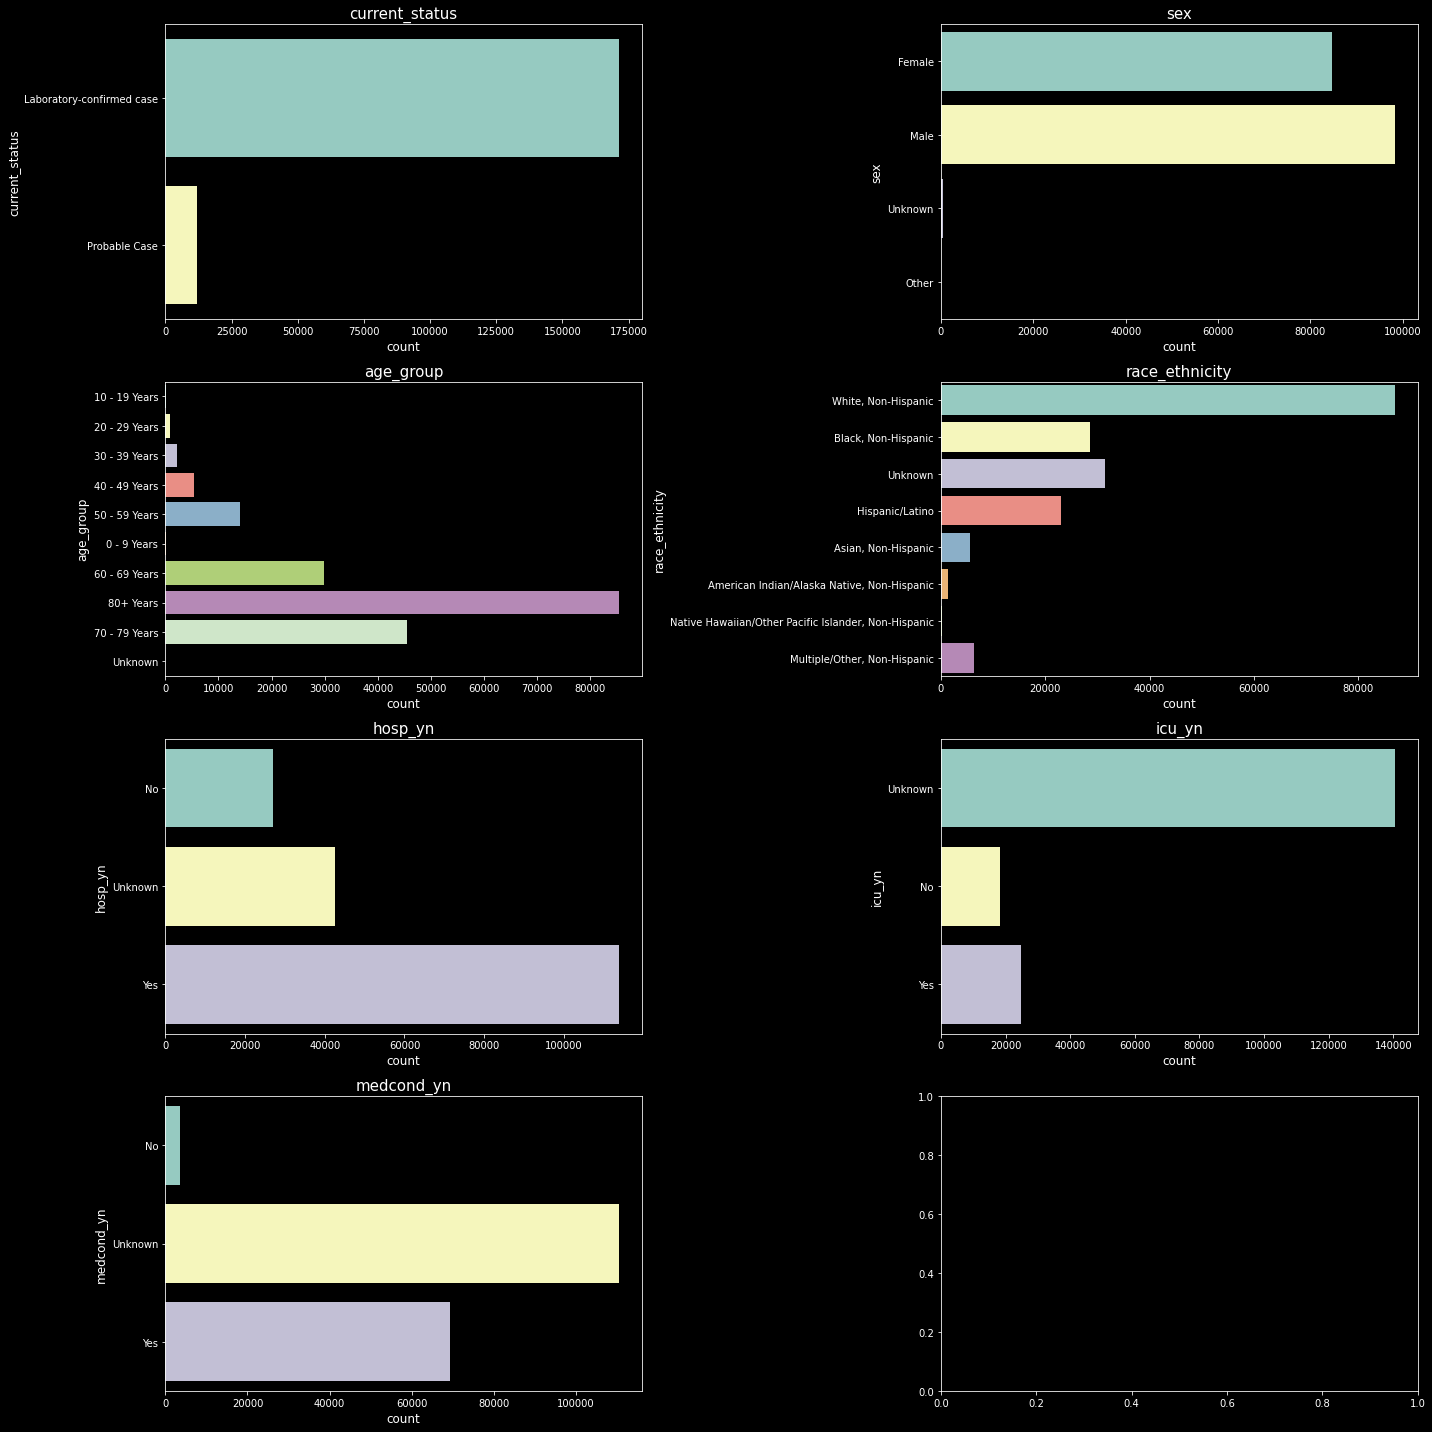

In [56]:
target_cols = ['current_status', 'sex', 'age_group', 'race_ethnicity', 'hosp_yn', 'icu_yn', 'medcond_yn']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
for i, col in enumerate(target_cols):
  ax_ = sns.countplot(y=col, data=death_df, ax=axes.flatten()[i])  
  ax_.set_title(label=col, fontdict=C_DICT)
    # Setting x-axis ticks and label color
  ax_.tick_params(axis='x', colors='white')
  ax_.xaxis.label.set_color('white')

  # Setting y-axis ticks and label color
  ax_.tick_params(axis='y', colors='white')
  ax_.yaxis.label.set_color('white')
plt.tight_layout()


>Of the patients that died, we notice that the majority of those who died required hospitalization. We also notice that the age_group that had the most deaths in our dataset were those 80 years old and older.

# PART 2

## Obtaining COVID CXR Images via Kaggle API

In [57]:
# !pip install kaggle

In [58]:
# Changing to the /content directory
%cd /content

/content


In [59]:
# Hiding my key by having a variable store the info
API_key = files.upload()

Saving kaggle.json to kaggle.json


In [60]:
# Creating a hidden folder then copying my API key and putting it in that file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [61]:
# Permissions of 600 mean that I (the owner) have full read and write access to the 
# file, while no other user can access or edit the file
!chmod 600 ~/.kaggle/kaggle.json

In [62]:
# Downloading the zipped dataset via Kaggle's API
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

100% 1.13G/1.14G [00:25<00:00, 56.5MB/s]
100% 1.14G/1.14G [00:25<00:00, 48.8MB/s]


In [63]:
# Unzipping the file and extracting to '/content' directory
from zipfile import ZipFile
f_name = "covid19-radiography-database.zip"
with ZipFile(f_name, 'r') as zipf:
      zipf.extractall()
      print('Done')

Done


In [64]:
# removing unnecessary files
!rm /content/covid19-radiography-database.zip

In [65]:
# Setting directory location back to root directory
%cd ~
%cd ..

/root
/


### Unzipping folder containing CXR images

In [66]:
def time_count(start, end):
  """
  Definition:
  Simple function that prints how many seconds it took to run from the 'start'
  variable to the 'end' variable.

  Args:
  start: Required. Usually a time.time() variable at the beginning of a cell.
  end: Required. Usually a time.time() variable at the end of a cell.

  Returns:
  Prints the difference in time between the 'start' and 'end' variables.
  """
  
  print(f"Time to run cell: {int(end-start)} seconds")

In [67]:
# setting a variable called base_folder that contains the directory of where 
# our chest x-ray images are
base_folder = '/content/COVID-19 Radiography Database'

In [68]:
# Viewing the contents within our base_folder
folder_contents(base_folder)

Contents of /content/COVID-19 Radiography Database:



['COVID',
 'COVID.metadata.xlsx',
 'NORMAL',
 'NORMAL.metadata.xlsx',
 'README.md.txt',
 'Viral Pneumonia',
 'Viral Pneumonia.metadata.xlsx']

#### Identifying the number of images in our dataset

In [69]:
def num_items(folder, targets=['/COVID', '/NORMAL', '/Viral Pneumonia'], verbose=True):
  """
  Definition:
  Adds up the number of files within each target folder and prints out the target
  folder name along with the total number of items in the folder. Also prints 
  the folder's directory path.

  Args:
  folder: Required. A filepath containing the data you wish to count.
  targets: default = ['/COVID', '/NORMAL', '/Viral Pneumonia']. Specify the target
  folders you wish to see how many items are contained within each.

  Returns:
  Prints out directory path, target folder names, and total number of items
  within each folder. Returns the 'num_items' variable.
  """
  if verbose:

    num_items = 0
    # Printing the folder address we are targeting
    print(folder)
    # the target is each subfolder within our folder 
    # (the default is NORMAL and PNEUMONIA)
    for target in targets:
        # counts the number of images within each target
        num_in_target = len(os.listdir(folder+target))
        # add the total number of images for each folder
        num_items += num_in_target
        print(f"Number of items in {target}: {num_in_target}")
    print(f"Total number of items: {num_items}")
    return num_items
  
  else:
    num_items = 0
    for target in targets:
        # counts the number of images within each target
        num_in_target = len(os.listdir(folder+target))
        # add the total number of images for each folder
        num_items += num_in_target
    return num_items

In [70]:
total_image_number = num_items(base_folder)

/content/COVID-19 Radiography Database
Number of items in /COVID: 1200
Number of items in /NORMAL: 1341
Number of items in /Viral Pneumonia: 1345
Total number of items: 3886


### Splitting our images into train, test, and validation sets

In [71]:
#making a temporary folder to store our train, test, and validation folders
os.makedirs('/content/cxr_folders', exist_ok=True)

#### Temporary Folder Creation & Check

In [72]:
# Using the splitfolders library to split our images into train, test, and validation
# subfolders by our desired ratio, and placing these subfolders in a new directory

# source of how to run: https://github.com/jfilter/split-folders
run = 1
if run:
  splitfolders.ratio(input=base_folder, 
                    output='/content/cxr_folders', 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio order: train, val, test
else:
  print('Did not run')

Copying files: 3886 files [00:09, 414.53 files/s]


In [73]:
# Checking the contents within our target folder

def folder_check(root_dir, orig_dir=None, subfolders=['/train', '/test', '/val'], 
                 check=0):
  """
  Definition:
  This funcion works best if splitfolders library was used to split data into 
  ratioed folders. The 'root_dir' must contain the folders defined in the 
  'subfolders' list. Counts the number of items for each class within 
  each subfolder. Checks the number of images to the original folder (optional).

  Args:
  root_dir: Required. Address of newly created folder.
  orig_dir: default = None. Address of original folder where images originated from.
  subfolders: default = ['/train', '/test', '/val']. Subfolders within the root_dir
  that contain the images.
  check: default = 1.

  Returns:
  Prints the total image count for all subfolders. Optionally prints boolean value
  if the total image count is equal to the total count of the orig_dir.
  """
  count_images = 0
  
  for folder in subfolders:
    targets = os.listdir(root_dir + folder)
    count_images += num_items(folder=root_dir + folder + '/', targets=targets)
    print()
  if check:
    total_image_number = num_items(orig_dir)
    print(f"Are the image numbers equal?\n{total_image_number == count_images}")

  print(f"\nTotal image count: {count_images}")

In [74]:
root_dir = '/content/cxr_folders'
folder_check(root_dir, orig_dir=base_folder, check=1)

/content/cxr_folders/train/
Number of items in Viral Pneumonia: 941
Number of items in COVID: 840
Number of items in NORMAL: 938
Total number of items: 2719

/content/cxr_folders/test/
Number of items in Viral Pneumonia: 270
Number of items in COVID: 240
Number of items in NORMAL: 269
Total number of items: 779

/content/cxr_folders/val/
Number of items in Viral Pneumonia: 134
Number of items in COVID: 120
Number of items in NORMAL: 134
Total number of items: 388

/content/COVID-19 Radiography Database
Number of items in /COVID: 1200
Number of items in /NORMAL: 1341
Number of items in /Viral Pneumonia: 1345
Total number of items: 3886
Are the image numbers equal?
True

Total image count: 3886


In [75]:
def create_ttv(root_dir):
  """
  Definition:
  Appends the string of each address within the 'root_dir' variable to the list 
  'ttv_list', sorts them by ABC order, and returns the list.

  Args:
  root_dir: Required. Specify a directory that contains train, test, and validation
  folders.

  Returns:
  The address of each train, test, and validation folder within the specified
  directory.
  """

  # adds a '/' to the end of the string address of 'root_dir' if there is not
  # already one there.
  if root_dir[-1] != '/':
    root_dir = root_dir + '/'
  # creating an empty list to hold addresses
  ttv_list = []
  for folder in os.listdir(root_dir):
    # creating and adding the string of each address to 'ttv_list'
    ttv_list.append(root_dir + folder + '/')
  # Sorting the list alphabetically to capture the correct addresses for each variable
  ttv_list.sort()
  test_folder = ttv_list[0]
  train_folder = ttv_list[1]
  val_folder = ttv_list[2]
  # returning the variables that each contain an address 
  return train_folder, test_folder, val_folder

In [76]:
# Creating variables to hold our addresses for our train, test, and val folders
train_folder, test_folder, val_folder = create_ttv('/content/cxr_folders')

In [77]:
train_folder

'/content/cxr_folders/train/'

In [78]:
def batch_sizes(folder_list=[]):
  """
  Definition:
  Creates batch sizes for each folder by counting the total number of items in 
  each folder. Appends these numbers to a list "batch" and returns the list. 
  Works best with the create_ttv() function.

  Args:
  folder_list: default = []. Pass in a list of folder directories that contain
  items you wish to be counted for batch sizes. 

  Returns:
  A list containing the batch sizes for each folder that was passed in.

  """
  batch = []
  for folder in folder_list:
    targets = os.listdir(folder)
    batch.append(num_items(folder, verbose=0, targets=targets))
  return batch

In [79]:
TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, VAL_BATCH_SIZE = batch_sizes([train_folder, 
                                                                 test_folder, 
                                                                 val_folder])
print(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, VAL_BATCH_SIZE)
print(TRAIN_BATCH_SIZE + TEST_BATCH_SIZE + VAL_BATCH_SIZE)

2719 779 388
3886


#### Setting up ImageDataGenerators

In [80]:
train_folder

'/content/cxr_folders/train/'

In [81]:
# Defining our image size
IMG_SIZE = (128, 128)

In [82]:
# Creating ImageDataGenerators for train and test/val
train_datagen = ImageDataGenerator(rescale=1./255)
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Creating an augmented IDG for train variables. Will use later on.
aug_datagen = ImageDataGenerator(zoom_range=0)

In [83]:
# Having each IDG using flow_from_directory by our defined batch sizes to create
# iterators that will spit out the entire set of data.
train_generator = train_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=TRAIN_BATCH_SIZE,
                                                   class_mode='categorical')

test_generator = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=TEST_BATCH_SIZE,
                                                     class_mode='categorical')

val_generator = test_val_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=VAL_BATCH_SIZE,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


In [84]:
# Viewing the classes within our iterator
train_generator.class_indices

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

In [85]:
list(train_generator.class_indices.items())

[('COVID', 0), ('NORMAL', 1), ('Viral Pneumonia', 2)]

In [86]:
# The batch size is equal to the total number of images within our training data
train_generator.batch_size

2719

In [87]:
start = time.time()
# Creating X and y values for train, test, and validation sets
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)
end = time.time()
time_count(start, end)

Time to run cell: 47 seconds


In [88]:
# Creating our INPUT_SHAPE variable that we will feed into our Neural Network
INPUT_SHAPE = X_train.shape[1:]
print(INPUT_SHAPE)

(128, 128, 3)


In [89]:
def random_image(X, y, verbose=0):
  """
  Definition:
  Selects a random number (i) within the range of the length of X. Then prints 
  the class label associated with that random number (i) along with the image
  associated with the specific X[i] array.

  Args:
  X: an np.array
  y: labels associated with the np.array

  Returns:
  Prints the class along with the y label, and displays the randomly selected image.
  """

  # Getting a random number within the range of our X variable
  i = np.random.choice(range(len(X)))
  # Determining what the label is and printing appropriate class
  if verbose:

    if y[i] == 0:
      print(f"COVID-19 : Class {y[i]}")
    elif y[i] == 1:
      print(f"NORMAL : Class {y[i]}")
    else:
      print(f"Viral Pneumonia : Class {y[i]}")
  else:
    if y[i] == 0:
      print(f"Class {y[i]}")
    elif y[i] == 1:
      print(f"Class {y[i]}")
    else:
      print(f"Class {y[i]}")
  # Displaying the image
  display(array_to_img(X[i]))

NORMAL : Class 1


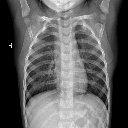

In [90]:
random_image(X_train, np.argmax(y_train, axis=1), verbose=1)

#### Baseline Model

In [91]:
# Creating and fitting our dummy classifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

# Creating our y_pred variable
y_pred = dummy.predict(X_test)

# We need to one-hot encode our classes from our generated labels in order for
# The confusion matrix to be able to digest any of it
y_pred = np.argmax(y_pred, axis=1)
y_test_ohe = np.argmax(y_test, axis=1)

              precision    recall  f1-score   support

           0       0.32      0.64      0.42       240
           1       0.36      0.26      0.30       269
           2       0.38      0.14      0.21       270

    accuracy                           0.34       779
   macro avg       0.35      0.35      0.31       779
weighted avg       0.35      0.34      0.31       779



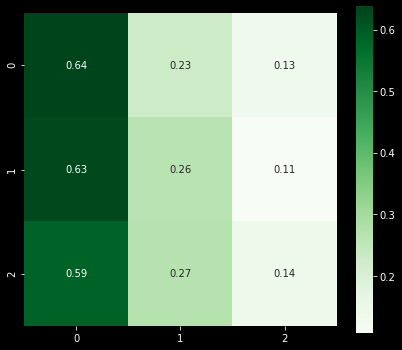

In [92]:
#Printing classification report and plotting confusion matrix
print(metrics.classification_report(y_test_ohe, y_pred));

plt.figure(figsize=(7, 6))
cm = metrics.confusion_matrix(y_test_ohe, y_pred, labels = [0, 1, 2], 
                              normalize='true')
sns.heatmap(cm, cmap="Greens", annot=True, square=True)
plt.show()

We built a baseline dummy classifier model that has an accuracy of 33%, and it tends to guess for the class == 0, which is our Covid class.

Since our dataset is relatively balanced in terms of classes, we expect to see the accuracy be around 33%.

#### Viewing our Class Weights

In [93]:
def make_class_weights(y_train, cls_weight='balanced', classification='binary'):
  """
  Definition:
  Creates a variable called 'class_weights' that is a list containing the weights
  for each class in the 'y_train' variable. This list is converted into a dictionary
  and returned.

  Args:
  y_train: Required. The labels of the data.
  cls_weight: default = 'balanced'. If ‘balanced’, class weights will be given 
  by n_samples / (n_classes * np.bincount(y)). If a dictionary is given, keys 
  are classes and values are corresponding class weights. If None is given, the 
  class weights will be uniform.
  classification: default = 'binary'. Determined by the number of classes present
  in the dataset. Currently this function can only support either 2 or 3 classes.

  Returns:
  A dictionary containing the class weights
  """
  if classification == 'multiclass':
    y_val = np.unique(np.argmax(y_train, axis=1))
    class_weights = class_weight.compute_class_weight(cls_weight, y_val, 
                                                      np.argmax(y_train, axis=1))
    class_weights_dict = dict(enumerate(class_weights))

  if classification == 'binary':
    y_val = np.unique(y_train)
    class_weights = class_weight.compute_class_weight(cls_weight, y_val, 
                                                  y_train)
    class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

  print(f"Our class weights:\n{class_weights_dict}")
  return class_weights_dict

In [94]:
class_weights_dict = make_class_weights(y_train, classification='multiclass')

Our class weights:
{0: 1.078968253968254, 1: 0.9662402274342573, 2: 0.963159759121502}


### Creating basic CNN Model

In [95]:
def create_basic_cnn(shape='',
                     metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall'), 
                              tf.keras.metrics.AUC(name='auc')]):
  """
  Definition:
  Creates a basic cnn model consisting of three layers and an output layer.

  Args:
  shape: this function requires an input shape in order for the model to be created.

  Returns:
  Returns a compiled model.
  """
  # We are requiring an input shape since we print the model.summary() at the 
  # end of the function
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    # Input layer
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D((2, 2)))

    # Second layer
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
      
    # Third layer
    model.add(Flatten())
    model.add(layers.Dense(128, activation='relu'))
      
    # Output layer
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())
    return model

In [96]:
basic_model = create_basic_cnn(shape=INPUT_SHAPE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7372928   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [97]:
def plot_history(history, metric_list=['acc', 'loss', 'precision', 'recall', 'auc']):
  """
  Definition:
  Creates a dataframe with a model.history variable. Then plots columns within the 
  dataframe if the column contains a metric within the metric list.

  Args:
  history: requires a model.history variable.
  metric_list: default = ['loss', 'acc']. Based on the metric's used in the model's 
  compiled metrics. 

  Returns:
  plots the columns that contain the metric within the metric list
  """
  # creating a dataframe of the model.history variable
  history_df = pd.DataFrame(history.history)

  with plt.style.context('seaborn'):    
    for metric in metric_list:
      history_df[[col for col in history_df.columns if metric in col]].plot(figsize=(8, 4), 
                                                                            marker='o')

      # Setting the title for each plot to be be the focused metric
      plt.title(metric.title())
      plt.grid(True)
      #sets the vertical range to [0-1]
      plt.gca().set_ylim(0, 1)
    plt.show()

In [98]:
def multi_class_report(model,X_test,y_test, class_indices=train_generator.class_indices, 
                 cmap='Reds'):
  """
  Definition:
  Prints out a classification report by predicting y_pred using model.predict() 
  and plots a heatmap of a confusion matrix using seaborn's heatmap() function. 

  Args:
  model: Requires a model.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  class_indices: default = train_set_full.class_indices. Pass through a dictionary
  that defines the classes. Must match up with the y_test labels.

  Returns:
  Prints out a classification report and a confusion matrix.  
  """
    
  # creating a title using the class_indices.items()
  title = ''
  for key, val in class_indices.items():
        title += key + ' = ' + str(val) + '    '
    
  # defining our prediction for multiple classification
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)

  y_test_ohe = np.argmax(y_test, axis=1)

  # Printing a classification report to see accuracy, recall, precision, f1-score
  dashes = '---'*19
  print(dashes)  
  print('                  Classification Report\n')
  print(metrics.classification_report(y_test_ohe, y_pred))
  print(dashes)
    
  # plots a normalized confusion matrix
  plt.figure(figsize=(7,6))
  conf_mat = metrics.confusion_matrix(y_test_ohe, y_pred, normalize='true')
  ax = sns.heatmap(conf_mat, cmap=cmap, annot=True, square=True)
  ax.set(xlabel='Predicted Class', ylabel='True Class')
  ax.set_ylim(3, 0)
  ax.set(title=title)
  plt.show()

In [99]:
def bin_class_report(model,X_test,y_test, class_indices=train_generator.class_indices, 
                 cmap='Reds'):
  """
  Definition:
  Prints out a classification report by predicting y_pred using model.predict() 
  and plots a heatmap of a confusion matrix using seaborn's heatmap() function. 

  Args:
  model: Requires a model.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  class_indices: default = train_set_full.class_indices. Pass through a dictionary
  that defines the classes. Must match up with the y_test labels.

  Returns:
  Prints out a classification report and a confusion matrix.  
  """
    
  # creating a title using the class_indices.items()
  title = ''
  for key, val in class_indices.items():
        title += key + ' = ' + str(val) + '    '
    
  # defining our prediction and rounding since we are dealing with binary classification
  y_pred = model.predict(X_test)
  y_pred = y_pred.round()

  # Printing a classification report to see accuracy, recall, precision, f1-score
  dashes = '---'*19
  print(dashes)  
  print('                  Classification Report\n')
  print(metrics.classification_report(y_test, y_pred))
  print(dashes)
    
  # plots a normalized confusion matrix
  conf_mat = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  ax = sns.heatmap(conf_mat, cmap=cmap, annot=True, square=True)
  ax.set(xlabel='Predicted Class', ylabel='True Class')
  ax.set_ylim(2, 0)
  ax.set(title=title)
  plt.show()

In [100]:
def fit_plot_report(model, X_train, y_train, X_val, y_val, X_test, y_test,
                generator, class_type='multi', epochs=10, batch_size=32, plot_hist=1, 
                class_weights=None, class_indices=train_generator.class_indices):
  """
  Definition:
  Fits a passed in model saved in a variable 'history'. Then activates the 
  class_report function which returns a classification report and a confusion
  matrix. Finally, plots the history using the plot_history() function.

  Args:
  model: Requires a model.
  X_train: Requires a train set of features.
  y_train: Requires a train set of labels.
  X_val: Requires a validation set of features.
  y_val: Requires a validation set of labels.
  X_test: Requires a test set of features.
  y_test: Requires a test set of labels.
  generator: Specify a generator to augment training data, this 
  variable will use the .flow() function to gather data from X_train and y_train 
  to augment the training data. 
  epochs: default = 10. Defines the number of passes the ML algorithm will complete.
  batch_size: default = 32. Defines the number of training examples utilized in
  one iteration before updating internal parameters.
  plot_hist: default = 1. Defines whether or not the plot_history() function will
  be executed. 
  class_weights: default = None. Pass in a dictionary containing the class weights, 
  where the keys are the classes and the values are the weights.

  Returns:
  history, prints classification report, confusion matrix, and plots history metrics.
  """
  start = time.time()
  history = model.fit(generator.flow(X_train, y_train, batch_size=batch_size), 
                        validation_data=(X_val, y_val), 
                        epochs=epochs, class_weight=class_weights)
  
  # Identifying the number of classes

  if class_type == 'multi':
    multi_class_report(model, X_test, y_test, class_indices=class_indices)
  elif class_type == 'binary':
    bin_class_report(model, X_test, y_test, class_indices=class_indices)
  else:
    print("Please choose either 'multi' or 'binary' when defining class type.")
    
  if plot_hist:
      plot_history(history) 

  dashes = '---'*20
  print(dashes)
  eval_scores = model.evaluate(X_test, y_test)
  metric_list=['loss', 'accuracy', 'precision', 'recall', 'auc']
  for i, score in enumerate(eval_scores):
    print(f"{metric_list[i]} score: {score}")
  print()
  end = time.time()
  time_count(start, end)
  return history

Epoch 1/10
85/85 [==============================] - 7s 21ms/step - loss: 1.1914 - acc: 0.6609 - precision: 0.7158 - recall: 0.5365 - auc: 0.8172 - val_loss: 0.2187 - val_acc: 0.9124 - val_precision: 0.9169 - val_recall: 0.9098 - val_auc: 0.9864
Epoch 2/10
85/85 [==============================] - 1s 11ms/step - loss: 0.1817 - acc: 0.9356 - precision: 0.9369 - recall: 0.9348 - auc: 0.9901 - val_loss: 0.2031 - val_acc: 0.9253 - val_precision: 0.9253 - val_recall: 0.9253 - val_auc: 0.9879
Epoch 3/10
85/85 [==============================] - 1s 11ms/step - loss: 0.1322 - acc: 0.9531 - precision: 0.9534 - recall: 0.9517 - auc: 0.9950 - val_loss: 0.2328 - val_acc: 0.9201 - val_precision: 0.9201 - val_recall: 0.9201 - val_auc: 0.9842
Epoch 4/10
85/85 [==============================] - 1s 11ms/step - loss: 0.0984 - acc: 0.9696 - precision: 0.9697 - recall: 0.9691 - auc: 0.9967 - val_loss: 0.1159 - val_acc: 0.9536 - val_precision: 0.9536 - val_recall: 0.9536 - val_auc: 0.9962
Epoch 5/10
85/85 [==

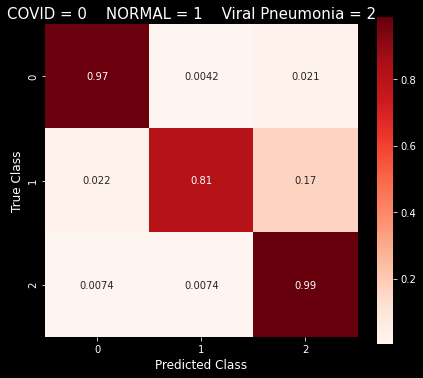

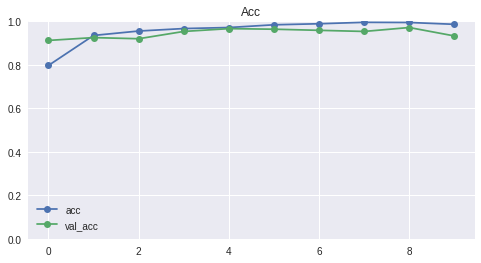

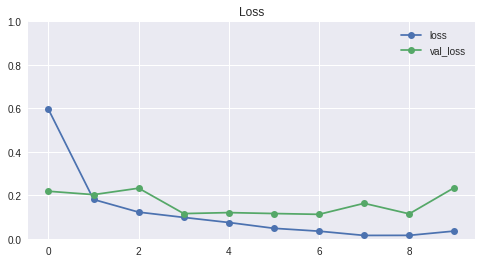

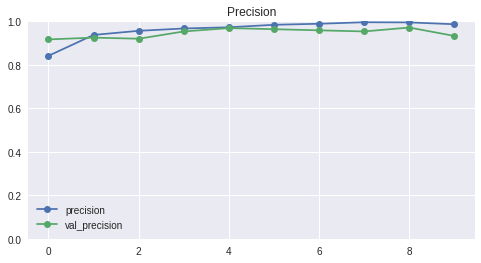

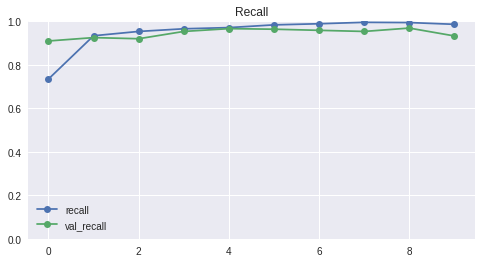

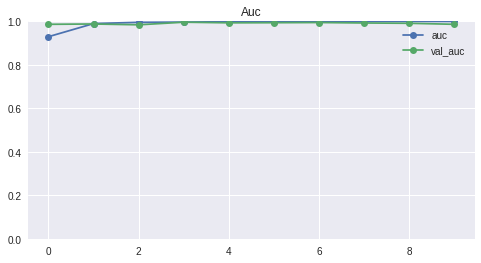

------------------------------------------------------------
25/25 [==============================] - 0s 7ms/step - loss: 0.3024 - acc: 0.9204 - precision: 0.9204 - recall: 0.9204 - auc: 0.9807
loss score: 0.302372545003891
accuracy score: 0.9204108119010925
precision score: 0.9204108119010925
recall score: 0.9204108119010925
auc score: 0.9806861877441406

Time to run cell: 18 seconds


In [101]:
hist1 = fit_plot_report(basic_model, X_train, y_train, X_val, y_val, X_test, y_test, 
                aug_datagen, class_weights=class_weights_dict, epochs=10)

### CLAHE Playground

link for info on cv2.createCLAHE():
 - https://docs.opencv.org/master/d6/dc7/group__imgproc__hist.html#gad689d2607b7b3889453804f414ab1018

In [102]:
img = cv2.imread('/content/cxr_folders/train/COVID/COVID (1).png', 0)
img.shape

(256, 256)

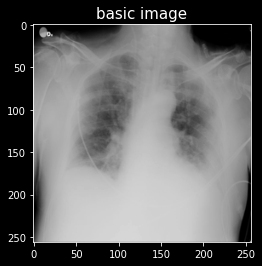

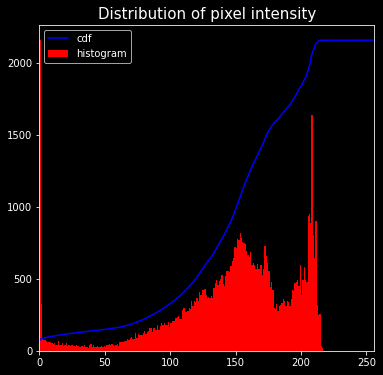

In [103]:
# Plotting an image to view, along with distribution of pixel intensity

plt.title('basic image')
plt.imshow(img, cmap='gray')
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.figure(figsize=(6, 6))
plt.title('Distribution of pixel intensity')
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


The next steps would be:
 - create preprocessed CLAHE images of each image in each train, test, and val folders 
 - place those pictures into the respective new class subfolders

### Creating CLAHE preprocessed images and placing them into new directory

In [104]:
base_folder = '/content/COVID-19 Radiography Database/'
new_folder = '/content/clahe_radio/'

def clahe_preprocessing(root_dir, new_dir):
  """
  Definition:
  from a specified directory 'root_dir', the function will loop through each
  subfolder and apply a clahe mask to each image and save that modified image in
  the 'new_dir' address.

  Args:
  root_dir: Required. The address of the directory that contains the subfolders
  holding the images.
  new_dir: Required. The directory where the modified images will be saved. This
  can be a directory that does not exist yet.

  Returns:
  Prints the time it took to run the function.
  """
  start = time.time()
  # creating our clahe mask to aply to images
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

  # Appending a '/' to the root_dir string if there is not already one
  if root_dir[-1] != '/':
    root_dir = root_dir + '/'

  # Looping through the subfolders in the root_dir
  for folder in os.listdir(root_dir):
    # If the end portion of an item within the folder contains something 
    # (eg: .png, .xlsx, .txt, etc.) the function will ignore it and continue;
    # it is only looking for subfolders to loop through.
    if os.path.splitext(folder)[-1].lower():
      continue

    # applying the clahe mask and saving the updated image to the new folder
    for image in os.listdir(root_dir + folder):
      img = cv2.imread(root_dir + folder + '/' + image, 0)
      cl_img = clahe.apply(img)
      os.makedirs(new_dir + folder, exist_ok=True)
      cv2.imwrite(new_dir + folder + '/' + image, cl_img)

  end = time.time()
  time_count(start, end)

In [105]:
clahe_preprocessing(base_folder, new_folder)

Time to run cell: 87 seconds


In [106]:
orig_img = cv2.imread('/content/COVID-19 Radiography Database/COVID/COVID (1).png')
clahe_img = cv2.imread('/content/clahe_radio/COVID/COVID (1).png')

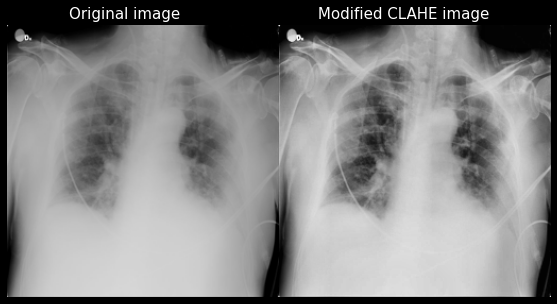

In [107]:
# Comparing original image (left) to CLAHE applied image (right)
res = np.hstack((orig_img,clahe_img))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.imshow(res, cmap='gray')
plt.title('Original image                             Modified CLAHE image')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()

We can definitely see more of the infiltrate in the lung areas of the chest x-ray. These infiltrate areas of the lung can determine whether or not a person has Pneumonia. As far as what radiologists look for in COVID-19 x-ray images, I would have to research further to find an answer. Whether or not the model would make anything of this preprocessing is TBD

In [108]:
# Splitting our preprocess image folder into train, test, and validation subfolders
# in a new directory

run=1

if run:
  splitfolders.ratio(input='/content/clahe_radio', 
                    output='/content/clahe_ttv', 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio of data sharing for
                                                    # train, test, val folders

Copying files: 3886 files [00:05, 657.86 files/s]


In [109]:
folder_check('/content/clahe_ttv', check=0)

/content/clahe_ttv/train/
Number of items in Viral Pneumonia: 941
Number of items in COVID: 840
Number of items in NORMAL: 938
Total number of items: 2719

/content/clahe_ttv/test/
Number of items in Viral Pneumonia: 270
Number of items in COVID: 240
Number of items in NORMAL: 269
Total number of items: 779

/content/clahe_ttv/val/
Number of items in Viral Pneumonia: 134
Number of items in COVID: 120
Number of items in NORMAL: 134
Total number of items: 388


Total image count: 3886


Defining new folders for our preprocessed chest x-ray images

In [110]:
train_folder, test_folder, val_folder = create_ttv('/content/clahe_ttv')

In [111]:
train_folder

'/content/clahe_ttv/train/'

Defining batch sizes for our preprocessed chest x-ray images

In [112]:
# Should be the same batch sizes as our previous image folders
TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, VAL_BATCH_SIZE = batch_sizes(folder_list=[
                                                                             train_folder, 
                                                                             test_folder, 
                                                                             val_folder])
# Still the same size as before
IMG_SIZE = (128, 128)

In [113]:
# We are still using the same imagedatagenerator as before to normalize our data,
# the 'train_datagen and test_val_datagen'
train_clahe_datagen = ImageDataGenerator(rescale=1./255)
test_val_clahe_datagen = ImageDataGenerator(rescale=1./255)

aug_clahe_datagen = ImageDataGenerator(zoom_range=0.1)


train_generator = train_clahe_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=TRAIN_BATCH_SIZE,
                                                   class_mode='categorical')

test_generator = test_val_clahe_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=TEST_BATCH_SIZE,
                                                     class_mode='categorical')

val_generator = test_val_clahe_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=VAL_BATCH_SIZE,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


In [114]:
start = time.time()
# Creating X and y values for train, test, and validation sets
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

end = time.time()
time_count(start, end)

Time to run cell: 29 seconds


In [115]:
INPUT_SHAPE = X_train.shape[1:]
INPUT_SHAPE

(128, 128, 3)

In [116]:
class_weights_dict = make_class_weights(y_train, classification='multiclass')

Our class weights:
{0: 1.078968253968254, 1: 0.9662402274342573, 2: 0.963159759121502}


In [117]:
basic_prep_cnn = create_basic_cnn(shape=INPUT_SHAPE)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

Epoch 1/10
85/85 [==============================] - 11s 121ms/step - loss: 1.5352 - acc: 0.5022 - precision: 0.8246 - recall: 0.6090 - auc: 0.8786 - val_loss: 0.3626 - val_acc: 0.8892 - val_precision: 0.8958 - val_recall: 0.8866 - val_auc: 0.9666
Epoch 2/10
85/85 [==============================] - 10s 115ms/step - loss: 0.2686 - acc: 0.8998 - precision: 0.9064 - recall: 0.8961 - auc: 0.9782 - val_loss: 0.1483 - val_acc: 0.9407 - val_precision: 0.9479 - val_recall: 0.9381 - val_auc: 0.9905
Epoch 3/10
85/85 [==============================] - 10s 117ms/step - loss: 0.2032 - acc: 0.9279 - precision: 0.9291 - recall: 0.9262 - auc: 0.9875 - val_loss: 0.3356 - val_acc: 0.9175 - val_precision: 0.9223 - val_recall: 0.9175 - val_auc: 0.9731
Epoch 4/10
85/85 [==============================] - 10s 116ms/step - loss: 0.1528 - acc: 0.9484 - precision: 0.9493 - recall: 0.9452 - auc: 0.9925 - val_loss: 0.2245 - val_acc: 0.9304 - val_precision: 0.9302 - val_recall: 0.9278 - val_auc: 0.9835
Epoch 5/10
8

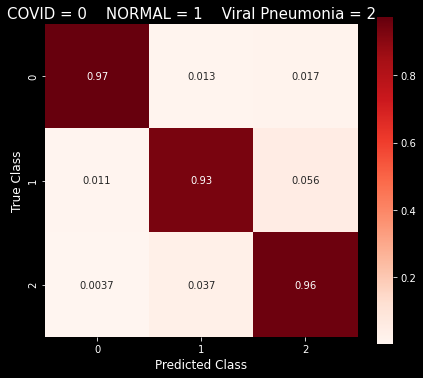

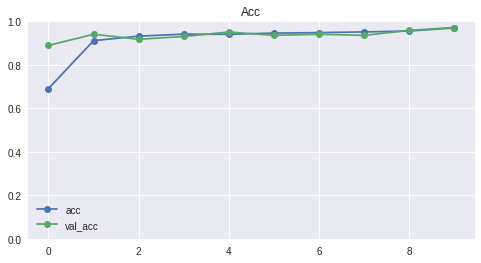

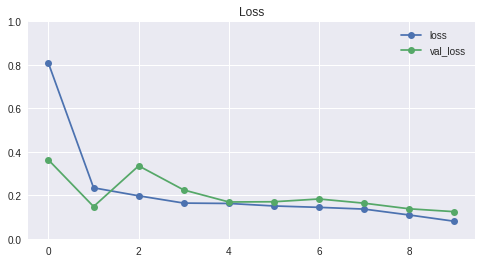

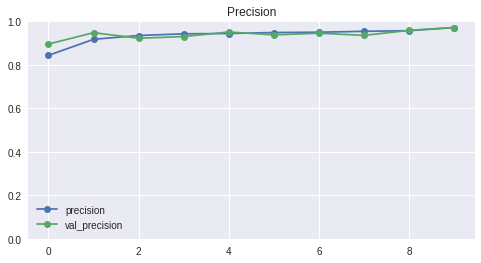

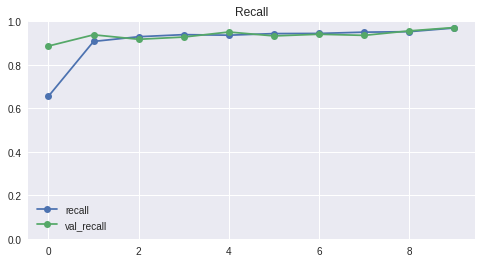

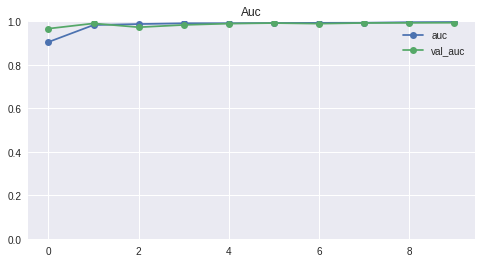

------------------------------------------------------------
25/25 [==============================] - 0s 7ms/step - loss: 0.1554 - acc: 0.9538 - precision: 0.9550 - recall: 0.9538 - auc: 0.9919
loss score: 0.15535840392112732
accuracy score: 0.9537869095802307
precision score: 0.955012857913971
recall score: 0.9537869095802307
auc score: 0.991855800151825

Time to run cell: 103 seconds


In [118]:
preprocessed_hist = fit_plot_report(basic_prep_cnn, X_train, y_train, X_val, y_val,
                                    X_test, y_test, generator=aug_clahe_datagen, 
                                    class_type='multi', 
                                    class_weights=class_weights_dict)

# PART 3

## Obtaining Virufy audio data

Finding the audio data proved to be more time consuming than finding chest x-ray data or the CDC dataset. 

In [119]:
# change the zipped_folder variable to match your filepath to access data
start = time.time()
zipped_folder = '/content/drive/MyDrive/virufy_data-main.zip'

fname = zipped_folder.split('/')[-1]

# Copying and unzipping the targeted file
!cp "{zipped_folder}" .
!unzip -q "{fname}" 
!rm "{fname}"
end = time.time()
time_count(start, end)

Time to run cell: 2 seconds


In [120]:
# Folder containing our segmented audio files
audio_base_folder = '/virufy_data-main/clinical/segmented/'

In [121]:
# Viewing subfolders in our audio_base_folder
folder_contents(audio_base_folder)

Contents of /virufy_data-main/clinical/segmented/:



['neg', 'pos']

In [122]:
# Counting the number of files in each subfolder
num_items(audio_base_folder, targets=['neg', 'pos'])

/virufy_data-main/clinical/segmented/
Number of items in neg: 73
Number of items in pos: 48
Total number of items: 121


121

In [123]:
start = time.time()

#Creating an empty dictionary to hold the duration for each file
audio_dict = {}
for folder in os.listdir(audio_base_folder):
  for mp3 in os.listdir(audio_base_folder + folder):
    signal, sr = librosa.load(audio_base_folder + folder + '/' + mp3)
    audio_dict[mp3] = librosa.get_duration(signal, sr)
    
end = time.time()
time_count(start, end)

Time to run cell: 83 seconds


In [124]:
# Viewing the mean, std, min, max, etc of the duration of our virufy audio
pd.Series(audio_dict.values()).describe()

count    121.000000
mean       1.599895
std        0.000029
min        1.599864
25%        1.599864
50%        1.599909
75%        1.599909
max        1.599955
dtype: float64

We see that the virufy audio data we have is all the same length (approx. 1.6 secs in length)

### Examining dataframe that came with the audio files

In [125]:
virufy_df = pd.read_csv('/virufy_data-main/clinical/labels.csv')

In [126]:
virufy_df.head()

,date,corona_test,age,gender,medical_history,smoker,patient_reported_symptoms,cough_filename
0,4/21,negative,53,male,"none,",yes,"none,",neg-0421-083-cough-m-53.mp3
1,4/21,positive,50,male,"Congestive heart failure,",no,"Shortness of breath,",pos-0421-084-cough-m-50.mp3
2,4/21,negative,43,male,"none,",no,"Sore throat,",neg-0421-085-cough-m-43.mp3
3,4/21,positive,65,male,"Asthma or chronic lung disease,",no,"Shortness of breath,New or worsening cough,",pos-0421-086-cough-m-65.mp3
4,4/21,positive,40,female,"none,",no,"Sore throat,Loss of taste,Loss of smell,",pos-0421-087-cough-f-40.mp3


In [127]:
virufy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   date                       16 non-null     object
 1   corona_test                16 non-null     object
 2   age                        16 non-null     int64 
 3   gender                     16 non-null     object
 4   medical_history            16 non-null     object
 5   smoker                     16 non-null     object
 6   patient_reported_symptoms  16 non-null     object
 7   cough_filename             16 non-null     object
dtypes: int64(1), object(7)
memory usage: 1.1+ KB


Note that our dataframe has 16 patients. While we have more audio data because the data was segmented, we should find more audio data if we want to train a model without worrying about overfitting to our small sample size.

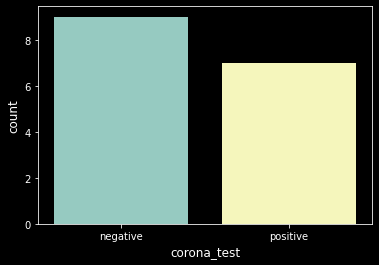

In [128]:
sns.countplot(x='corona_test', data=virufy_df)
plt.show()

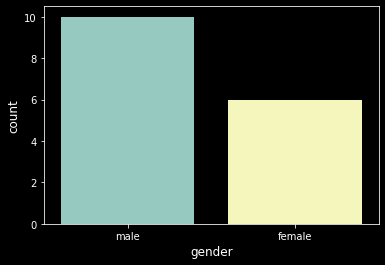

In [129]:
sns.countplot(x='gender', data=virufy_df)

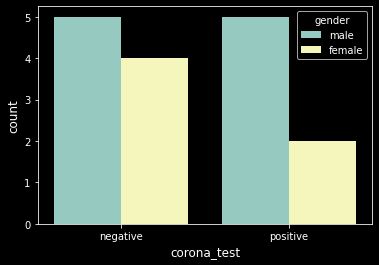

In [130]:
sns.countplot(x='corona_test', hue='gender', data=virufy_df)

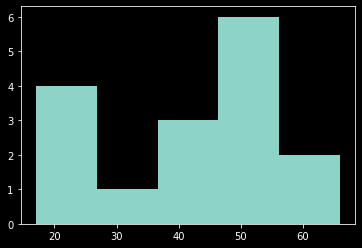

In [131]:
plt.hist(x='age', data=virufy_df, bins='auto')
plt.show()

In [132]:
virufy_df['medical_history'].value_counts()

none,                              12
Diabetes with complications,        2
Asthma or chronic lung disease,     1
Congestive heart failure,           1
Name: medical_history, dtype: int64

In [133]:
virufy_df['patient_reported_symptoms'].value_counts()

none,                                                                                                             6
Shortness of breath,New or worsening cough,                                                                       2
New or worsening cough,                                                                                           2
Sore throat,Loss of taste,Loss of smell,                                                                          1
Shortness of breath,                                                                                              1
Fever, chills, or sweating,New or worsening cough,Sore throat,                                                    1
Shortness of breath,Sore throat,Body aches,                                                                       1
Sore throat,                                                                                                      1
Fever, chills, or sweating,Shortness of breath,New or worsening cough,So

In [134]:
asympto_df = virufy_df[virufy_df['patient_reported_symptoms'] == 'none,']

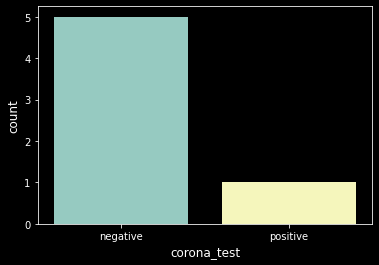

In [135]:
# The majority of patients in this dataset who had COVID-19 did have at least 
# one symptom. Only one patient was asymptomatic.
sns.countplot(x='corona_test', data=asympto_df);

### Audio Playground

In [138]:
# list of our first 10 virufy audio files in the 'pos' subfolder
os.listdir(audio_base_folder + 'pos')[:10]

['pos-0421-092-cough-m-53-7.mp3',
 'pos-0421-092-cough-m-53-3.mp3',
 'pos-0421-086-cough-m-65-1.mp3',
 'pos-0421-086-cough-m-65-8.mp3',
 'pos-0421-087-cough-f-40-1.mp3',
 'pos-0421-086-cough-m-65-6.mp3',
 'pos-0421-086-cough-m-65-0.mp3',
 'pos-0421-092-cough-m-53-1.mp3',
 'pos-0421-084-cough-m-50-5.mp3',
 'pos-0421-084-cough-m-50-2.mp3']

Viewing an audiofile using librosa

In [139]:
audio_example = os.listdir(audio_base_folder +'pos')[3]
audio_example

'pos-0421-086-cough-m-65-8.mp3'

In [140]:
target_audio = audio_base_folder+'pos/'+audio_example
target_audio

'/virufy_data-main/clinical/segmented/pos/pos-0421-086-cough-m-65-8.mp3'

In [141]:
# two variables: the signal and the sample rate

#loading in a specific example to test out
signal, sr = librosa.load(target_audio, sr=22050)

In [142]:
# Librosa gives us back an array --> our audio signal
# and a number which represents our sample rate
# sample rate is how many samples we have in a second
# We get back the default sample rate, which is 22050
print(type(signal), type(sr))
print(signal.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(35278,) 22050


In [143]:
#Multiplying our sample rate by the length of our audio file
# It should give us back a float very close to the shape of our signal
22050 * 1.5999

35277.795000000006

In [144]:
# Viewing the internals of our signal variable
signal[:10]

array([ 0.02902813,  0.08093203,  0.11140069,  0.07776356, -0.01012611,
       -0.09276348, -0.11523346, -0.05964312,  0.01504819,  0.04232807],
      dtype=float32)

In [145]:
# listening to the audio file
ipd.Audio(signal, rate=sr)

Visualizing our audio example's waveform using librosa.display (ldp)


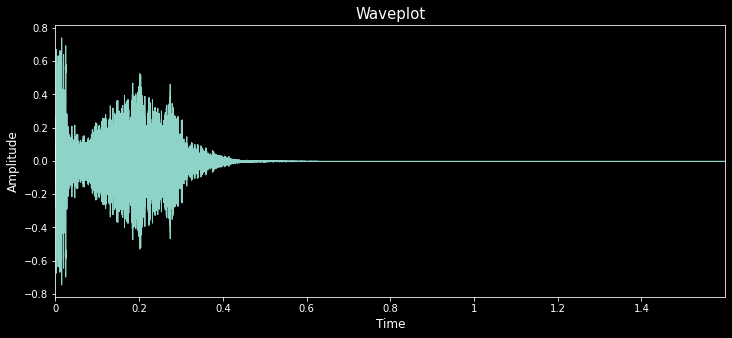

In [146]:
plt.figure(figsize=(12, 5))
ldp.waveplot(signal, sr=sr)
plt.title('Waveplot')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Text(0, 0.5, 'Magnitude')

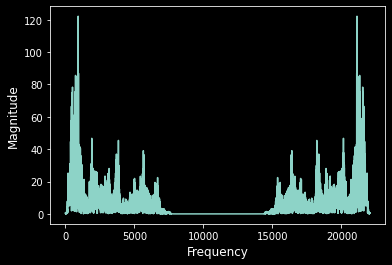

In [147]:
#Fast Fourier Transform
fft = np.fft.fft(signal)

# These magnitudes indicate the contribution of each frequency in the sound. The
# larger the magnitude, the heavier the contribution of the frequency.
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

# Plotting our Fast Fourier Transformation
plt.plot(frequency, magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

We notice the Fast Fourier Transformation plot is actually symmetrical. Without getting into too much detail (unnecessary for what we are doing), we only need the first half of the plot.

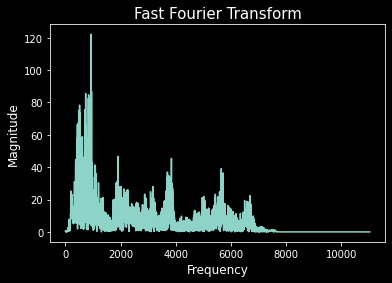

In [148]:
#Fast Fourier Transformation
fft = np.fft.fft(signal)

# These magnitudes indicate the contribution of each frequency in the sound
magnitude = np.abs(fft)

# mapping the magnitude to the relative frequency bins using np.linspace()
frequency = np.linspace(0, sr, len(magnitude))

# We only need the first half of the magnitude and frequency to visualize the FFT
left_mag = magnitude[:int(len(magnitude)/2)]
left_freq = frequency[:int(len(frequency)/2)]

plt.plot(left_freq, left_mag)
plt.title('Fast Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

Here we can see that the majority of the energy resides in the lower frequencies. The only issue with the FFT is the fact that it is static; there is no time associated with this plot. So in order to incorporate time into our audio to see what frequencies impact at what time, we should use the Short-Time Fourier Transformation.

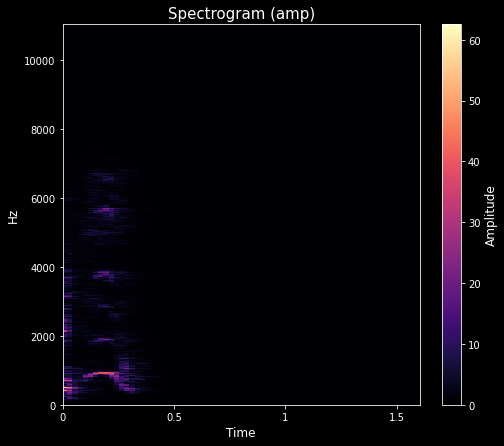

In [149]:
# number of samples per fft
# this is the number of samples in a window per fast fourier transform
n_fft = 2048

# The amount we are shifting each fourier transform (to the right)
hop_length = 512

#Trying out Short-time Fourier Transformation on our audio data
audio_stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

# gathering the absolute values for all values in our audio_stft variable
spectrogram = np.abs(audio_stft)

# Plotting the short-time Fourier Transformation
plt.figure(figsize=(8, 7))
ldp.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz', hop_length=hop_length)
plt.colorbar(label='Amplitude')
plt.title('Spectrogram (amp)')
plt.show()

As we can see (or not see), most of the frequencies in our audio contribute very little amplitude to the overall sound. 

Because what we are looking for is not linear, like loudness, we are going to take the log of our sounds amplitude and turn it into decibels.

Humans experience frequency logarithmically, not linearly.

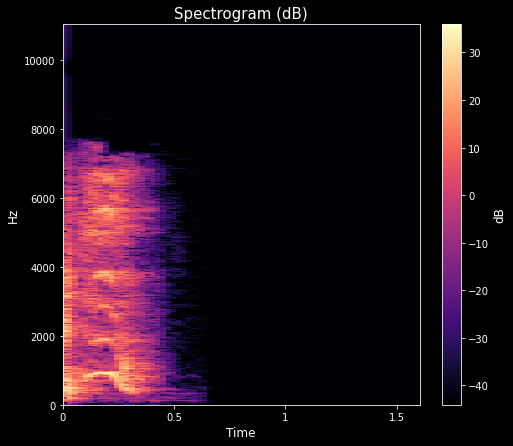

In [150]:
# Creating short-time Fourier Transformation
audio_stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

# converting values to absolute values
spectrogram = np.abs(audio_stft)

# here we are switching from amplitude scaling to decibel scaling
log_spectro = librosa.amplitude_to_db(spectrogram)

# Plotting the short-time fourier transformation
plt.figure(figsize=(8, 7))
ldp.specshow(log_spectro, sr=sr, x_axis='time', y_axis='hz', 
             hop_length=hop_length, cmap='magma')
plt.colorbar(label='dB')
plt.title('Spectrogram (dB)')
plt.show()

>By switching from a scale in amplitude to decibels, we create an image with more information to give to our model.

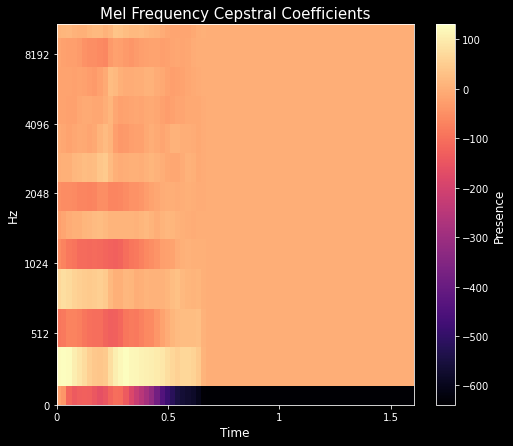

In [151]:
# Messing with MFCC plot. This type of plot is unnecessary for what we are doing.
mfccs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# PLotting the MFCCs
plt.figure(figsize=(8, 7))
ldp.specshow(mfccs, sr=sr, x_axis='time', y_axis='mel',
             hop_length=hop_length, cmap='magma')
plt.colorbar(label='Presence')
plt.title('Mel Frequency Cepstral Coefficients')
plt.show()

Fourier Transform:
- decompose complex periodic sound into sum of sine waves oscillating at different frequencies
- allows us to know the different elements that create a complex sound
- moves our audio from the time domain into the frequency domain
- it's a snapshot of the audio information

Short-Time Fourier Transform:
- computes several fourier transforms at different intervals
- doing so allows it to preserve information about time and the way the sound evolves over time
- makes it a time domain feature
- the amount different intervals are indicated by the frame size, which creates a spectrogram
- x-axis = time
- y-axis = frequency
- third axis = presence of a frequency
- the color tells us how prominent a certain frequency is at a certain period in time

Mel Frequency Cepstral Coefficients (MFCCs):
- Captures the timbral/textural aspects of sound
- time domain feature
- Approximated towards the human auditory system
- calculated at each frame
- usually want to use 13-40 coefficients for audio data
- usually used for speech recognition, music genre classification, music instrument classification
- could use MFCCs to help collect coughing audio data?

Mel Spectrograms:
- time-frequency representation
- perceptually relevant amplitude representation
- preceptually relevant frequency representation
- steps: extract stft, convert amplitude to dBs, convert frequency to mel-scale

to convert frequencies to the mel-scale:
1. choose a number of mel bands
2. construct mel filter banks
3. Apply filter banks to mel spectrogram

How many mel bands should you choose? Like learning rate, it depends on the problem.


In [152]:
def to_spectrogram(signal, sr, hop_length, n_fft=2048, cmap='magma'):
  """
  Definition:
  Plots a spectrogram of a signal.

  Args:
  signal: Required. An audio time series, usually an numpy 1 dimensional array.
  sr: Required. The sample rate of the signal.
  hop_length: Required. The amount to shift each fast fourier transform.
  n_fft: Required. The number of samples in a window per fast fourier transform.
  cmap: default = 'magma'. The color palette of the spectrogram.

  Returns:
  Plots a spectrogram via librosa.display.specshow()
  """
  stft_signal = librosa.core.stft(y=signal, hop_length=hop_length, n_fft=n_fft)
  spectrogram = np.abs(stft_signal)
  amp_to_db = librosa.amplitude_to_db(spectrogram)
  plt.figure(figsize=(10, 8))
  ldp.specshow(amp_to_db, sr=sr, x_axis='time', y_axis='hz', cmap=cmap, 
               hop_length=hop_length)
  plt.colorbar(label='dB')

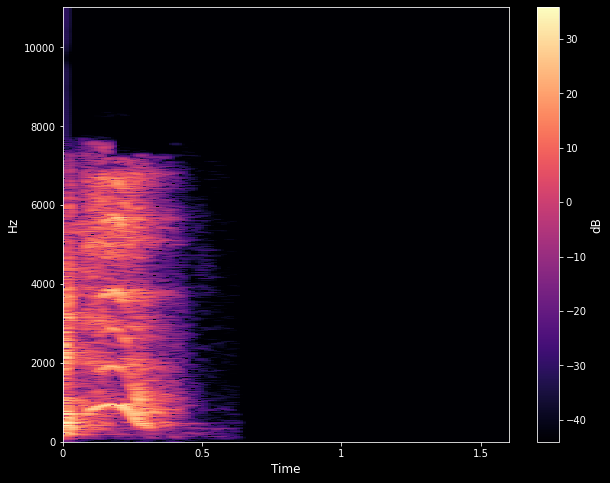

In [153]:
to_spectrogram(signal, sr=22050, hop_length=256, n_fft=2048)

Raw info for plotting mel spectrogram - info retrieved from: https://medium.com/gradientcrescent/urban-sound-classification-using-convolutional-neural-networks-with-keras-theory-and-486e92785df4

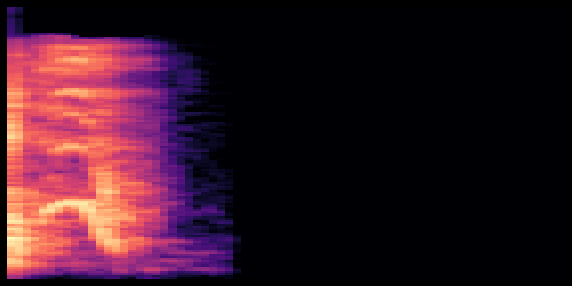

In [154]:
# Calling plt.interactive(False) means that we choose to manually show and destroy
# our plots 
plt.interactive(False)

# The audio signal and sample rate
signal, sr = librosa.load(audio_base_folder + 'pos/' + audio_example)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# Hiding axes and image frame
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)

# Trying out the mel-scaled spectrogram
mel_spectro = librosa.feature.melspectrogram(y=signal, sr=sr)
#ref=np.max -> computing to peak power
librosa.display.specshow(data=librosa.power_to_db(mel_spectro, ref=np.max))
plt.show()

In [155]:
plt.close('all')

#### defining mel spectrogram function

In [156]:
def to_mel_spectro(signal, sr, hop_length, n_fft, cmap='magma', 
                    ref=np.max, figsize=(10, 8)):
  """
  Definition:
  Plots a mel-spectrogram of a signal.

  Args:
  signal: Required. An audio time series, usually an numpy 1 dimensional array.
  sr: Required. The sample rate of the signal.
  hop_length: Required. The amount to shift each fast fourier transform.
  n_fft: Required. The number of samples in a window per fast fourier transform.
  cmap: default = 'magma'. The color palette of the spectrogram.
  ref: default = np.max. Tells the librosa.power_to_db() how to scale the values.
  When ref=np.max, it will make the highest value 0, and everything else will be 
  lower than it, respectively so. Does not change the color distribution of the
  spectrogram.
  figsize: default = (10, 8). A tuple representing the desired figure size for 
  the plot.

  Returns:
  Plots a spectrogram via librosa.display.specshow()
  """

  mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, 
                                              n_fft=n_fft)
  spectrogram = np.abs(mel_signal)
  power_to_db = librosa.power_to_db(spectrogram, ref=ref)
  plt.figure(figsize=figsize)
  ldp.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap=cmap, 
              hop_length=hop_length)
  plt.colorbar(label='dB')
  plt.show()

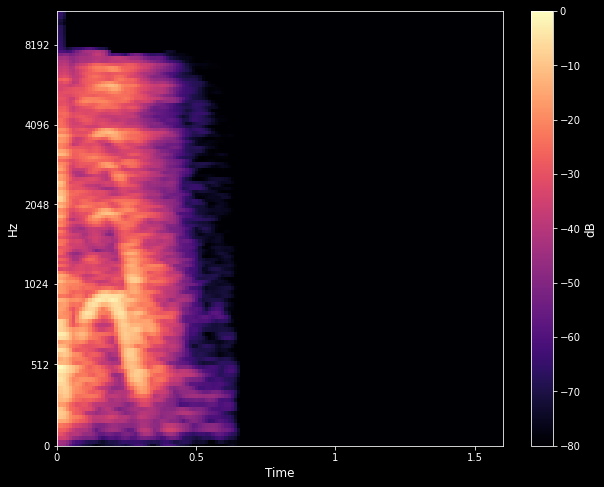

In [157]:
to_mel_spectro(signal, sr, hop_length=256, n_fft=2048)

### Creating & Saving Mel-Spectrograms for Virufy Dataset

In [158]:
# Defining our target folder and constant variables
root_folder = '/virufy_data-main/clinical/segmented'
SAMPLE_RATE = 22050
HOP_LENGTH = 256
N_FFT = 2048

start = time.time()

# Going through 'pos' and 'neg' folders in root folder
for status in os.listdir(root_folder):

  # Identifying correct directory for each 'pos' and 'neg' subfolder and
  # accessing each audio file within these folders
  step = root_folder + '/' + status
  for subfile in os.listdir(step):
    # Creating a variable that holds the filepath for an audio file
    audio_file = step + '/' + subfile
    # Loading the signal and sample rate for an audio file
    signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)

    # Calling plt.interactive(False) means that we choose to manually show and destroy
    # our plots 
    plt.interactive(False)

    # Creating our mel-spectrograms
    mel_signal = librosa.feature.melspectrogram(y=signal, sr=SAMPLE_RATE, 
                                                hop_length=HOP_LENGTH, 
                                                n_fft=N_FFT)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    # Creating figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    # Hiding axes and image frame
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    # Displaying our spectrograms
    ldp.specshow(power_to_db, sr=SAMPLE_RATE, cmap='magma', hop_length=HOP_LENGTH)
    # making folder to store images
    new_folder = '/spectro_images/' + status + '/'
    os.makedirs(new_folder , exist_ok=True)
    
    # Saving each spectrogram into its respective folder
    # subfile[:-4] is a string of the subfile without the ending extension '.mp3'
    # We add the '.png' extension to the end of our new spectrogram images instead
    plt.savefig(fname=new_folder + subfile[:-4] + '.png', dpi=400, 
                bbox_inches='tight',pad_inches=0)
    
    # We then manually close pyplot, clear the figure, close the fig variable, 
    # and then close the figure window
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')

# Display the time it took to run the cell in seconds
end = time.time()
time_count(start, end)

Time to run cell: 230 seconds


In [159]:
# # Functionizing the above code

# # Defining our target folder and constant variables
# root_folder = '/virufy_data-main/clinical/segmented/'
# SAMPLE_RATE = 22050
# HOP_LENGTH = 256
# N_FFT = 2048

# def create_save_mel_spectros(root_folder, new_folder_base, sr=22050, 
#                              hop_length=256, n_fft=2048):
    
#   start = time.time()

#   # Going through 'pos' and 'neg' folders in root folder
#   for status in os.listdir(root_folder):

#     # Identifying correct directory for each 'pos' and 'neg' subfolder and
#     # accessing each audio file within these folders
#     step = root_folder + status
#     for subfile in os.listdir(step):
#       # Creating a variable that holds the filepath for an audio file
#       audio_file = step + '/' + subfile
#       # Loading the signal and sample rate for an audio file
#       signal, sr = librosa.load(audio_file, sr=sr)

#       # Calling plt.interactive(False) means that we choose to manually show and destroy
#       # our plots 
#       plt.interactive(False)

#       # Creating our mel-spectrograms
#       mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, 
#                                                   hop_length=hop_length, 
#                                                   n_fft=n_fft)
#       spectrogram = np.abs(mel_signal)
#       power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
#       # Creating figure
#       fig = plt.figure(figsize=(10, 8))
#       ax = fig.add_subplot(111)
#       # Hiding axes and image frame
#       ax.axes.get_xaxis().set_visible(False)
#       ax.axes.get_yaxis().set_visible(False)
#       ax.set_frame_on(False)

#       # Displaying our spectrograms
#       ldp.specshow(power_to_db, sr=sr, cmap='magma', hop_length=hop_length)
#       # making folder to store images
#       new_folder = new_folder_base + status + '/'
#       os.makedirs(new_folder, exist_ok=True)
      
#       # Saving each spectrogram into its respective folder
#       # subfile[:-4] is a string of the subfile without the ending extension '.mp3'
#       # We add the '.png' extension to the end of our new spectrogram images instead
#       plt.savefig(fname=new_folder + subfile[:-4] + '.png', dpi=400, 
#                   bbox_inches='tight',pad_inches=0)
      
#       # We then manually close pyplot, clear the figure, close the fig variable, 
#       # and then close the figure window
#       plt.close()    
#       fig.clf()
#       plt.close(fig)
#       plt.close('all')

#   # Display the time it took to run the cell in seconds
#   end = time.time()
#   time_count(start, end)

In [160]:
# Comparing pos and neg spectrogram images we created
neg_img = mpimg.imread('/spectro_images/neg/neg-0421-083-cough-m-53-0.png')
pos_img = mpimg.imread('/spectro_images/pos/pos-0421-084-cough-m-50-0.png')

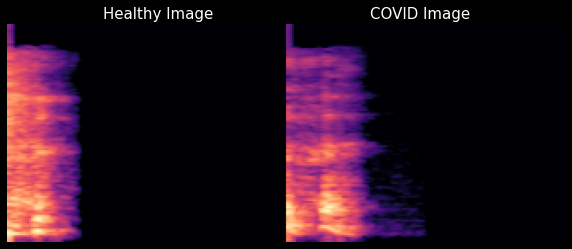

In [161]:
# Using np.hstack() to show our images side by side
res = np.hstack((neg_img, pos_img))
# Creating a figure and adding a subplot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# plotting the horizontal stack using plt.imshow()
plt.imshow(res, cmap='gray')
plt.title('Healthy Image                                 COVID Image')

# Hiding our axes and frame
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()

When looking at the spectrograms, there's not much we can take away just by looking at them. We notice the coughs are roughly the same length in duration, and the prominence of some frequencies of sound may be slightly different when comparing patients (male vs female, older vs younger, etc). 

#### Thoughts on extending the length of audio data

Since our first audio dataset consists of audio files with the exact length of 1.6 seconds, and our second dataset consists of audiofiles with a length of up to 10 seconds, we will need to fill in silent frames into our smaller audio files.

link: https://stackoverflow.com/questions/46757852/adding-silent-frame-to-wav-file-using-python

In [162]:
# Address of example we are going to work with
target_audio

'/virufy_data-main/clinical/segmented/pos/pos-0421-086-cough-m-65-8.mp3'

In [163]:
signal, sr = librosa.load(target_audio)
max_duration = 1.6 # in seconds
duration = librosa.get_duration(signal, sr)
print(duration)

1.5999092970521542


In [164]:
silent_length = (max_duration*1000) - (duration*1000)
print(int(silent_length))

0


In [165]:
# creating 8.4 secs of audio silence -- duration in milliseconds
silent_segment = AudioSegment.silent(duration=silent_length)

In [166]:
#read our target wav file example to an audio segment
cough_audio = AudioSegment.from_mp3(target_audio)

In [167]:
# Combining our silent segment with the audio example
extended_cough = cough_audio + silent_segment

In [168]:
# Viewing our extended_cough variable's type
type(extended_cough)

pydub.audio_segment.AudioSegment

In [169]:
# making a folder to hold our extended audio example
os.makedirs('/ext_audio_test', exist_ok=True)

In [170]:
extended_cough.export(out_f='/ext_audio_test/extended_cough2.mp3')

<_io.BufferedRandom name='/ext_audio_test/extended_cough2.mp3'>

In [171]:
signal, sr = librosa.load('/ext_audio_test/extended_cough2.mp3', sr=22050)

In [172]:
ipd.Audio(signal, rate=sr)

In [173]:
# length of our extended audio file
duration = librosa.get_duration(signal, sr)
print(duration)

1.5999092970521542


In [174]:
shutil.rmtree('/ext_audio_test')

## Importing CoughVid audio data

### Unzipping folder

In [ ]:
# Extracting the contents of our cooughvid zipped folder

start = time.time()
file_name='/content/drive/MyDrive/public_dataset.zip'
with ZipFile(file_name,'r') as zip:
      zip.extractall()
      print('Done')
end = time.time()
time_count(start, end)

Done
Time to run cell: 20 seconds


In [ ]:
# Reading in the csv file into a dataframe
coughvid_df = pd.read_csv('/public_dataset/metadata_compiled.csv')

In [ ]:
coughvid_df.head()

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,cough_type_3,diagnosis_3,severity_3
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,31.3,34.8,15.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,40.0,-75.1,34.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,-16.5,-71.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,2020-04-13T22:23:06.997578+00:00,0.9968,NaN,NaN,21.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001c85a8-cc4d-4921-9297-848be52d4715,2020-04-17T15:24:35.822355+00:00,0.0735,40.6,-3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


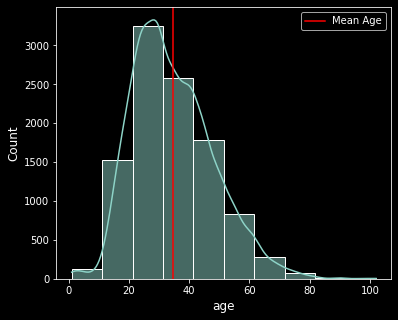

In [ ]:
# Viewing the distribution of age in coughvid dataset
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=coughvid_df, x='age', bins=10, kde=True)
plt.axvline(x=coughvid_df['age'].mean(), c = 'r', label='Mean Age')
plt.legend()
plt.show()

### Column information

>- **uuid**: The address of the associated audio and json file for a patient.
- **datetime**: Timestamp of the received recording in ISO 8601
format.
- **cough_detected**: Probability that the recording contains cough sounds, according to the automatic detection algorithm
that was used by Orlandic et al.
- **latitude**: Self-reported latitude geolocation coordinate with reduced precision.
- **longitude**: Self-reported longitude geolocation coordinate with reduced precision.
- **age**: Self-reported age value.
- **gender**: Self-reported gender.
- **respiratory_condition**: If the patient has other respiratory conditions (self-reported).
- **fever_muscle_pain**: If the patient has a fever or muscle pain (self-reported).
- **status**: The patient self-reports that has been diagnosed with COVID-19 (COVID), that has symptoms but no diagnosis (symptomatic), or that is healthy (healthy).

>Within the next set of columns, it is important to know that 3 expert pulmonologists were each assigned with revising 1000 recordings to enhance the quality of the dataset with clinically validated information. They selected one of the predefined options to each of the following 10 items:



>**Categorical Columns**:
- **quality**: quality of the recorded cough sound.
  - values: {good, ok, poor, no_cough} 
- **cough_type**: Type of the cough.
  - values:  {wet, dry, unknown}
- **diagnosis**: Impression of the expert about the condition of the patient. It can be an upper or lower respiratory tract
infection, an obstructive disease (Asthma, COPD, etc), COVID-19, or a healthy cough.
  - values: {upper_infection, lower_infection, obstructive_disease, COVID-19, healthy_cough}
- **severity**: Impression of the expert about the severity of the cough. It can be a pseudocough from a healthy patient, a mild or severe cough from a sick patient, or unknown if the expert can’t tell.
  - values: {pseudocough, mild, severe, unknown}

>**Boolean Columns**:
- **dyspnea**: Presence of any audible dyspnea.
- **wheezing**: Presence of any audible wheezing.
- **stridor**: Presence of any audible stridor.
- **choking**: Presence of any audible choking.
- **congestion**: Presence of any audible nasal congestion.
- **nothing**: Nothing specific is audible.


In [ ]:
print("Percent of null values for each column:")
for col in coughvid_df.columns:
  print(f"{col}: {round(coughvid_df[col].isna().sum()/len(coughvid_df), 3)}")

Percent of null values for each column:
uuid: 0.0
datetime: 0.0
cough_detected: 0.0
latitude: 0.415
longitude: 0.415
age: 0.478
gender: 0.436
respiratory_condition: 0.436
fever_muscle_pain: 0.436
status: 0.436
quality_1: 0.959
cough_type_1: 0.959
dyspnea_1: 0.959
wheezing_1: 0.959
stridor_1: 0.959
choking_1: 0.959
congestion_1: 0.959
nothing_1: 0.959
diagnosis_1: 0.959
severity_1: 0.959
quality_2: 0.959
cough_type_2: 0.959
dyspnea_2: 0.959
wheezing_2: 0.959
stridor_2: 0.959
choking_2: 0.959
congestion_2: 0.959
nothing_2: 0.959
diagnosis_2: 0.959
severity_2: 0.959
quality_3: 0.959
dyspnea_3: 0.959
wheezing_3: 0.959
stridor_3: 0.959
choking_3: 0.959
congestion_3: 0.959
nothing_3: 0.959
cough_type_3: 0.96
diagnosis_3: 0.96
severity_3: 0.96


We see that the majority of our data have missing values in the expert columns. This is expected because they each reviewed only 1000 audio files, therefore the majority of these values should be missing. Also note that about 15% of the recordings were labeled by all three reviewers, so that Orlandic et al. could assess the level of agreement among the pulmonologists.


In [ ]:
# Dataframe containing rows that were reviewed by one or more pulmonologist
expert_df = coughvid_df[(coughvid_df['quality_1'].notnull()) | 
                        (coughvid_df['quality_2'].notnull()) | 
                        (coughvid_df['quality_3'].notnull())]

In [ ]:
len(expert_df)

2200

In [ ]:
expert_df.head()

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,cough_type_3,diagnosis_3,severity_3
11,002db0bd-e57f-4c30-ade0-16640d424eb7,2020-04-13T19:51:11.397697+00:00,0.9536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,False,False,False,True,unknown,healthy_cough,pseudocough
27,005b8518-03ba-4bf5-86d2-005541442357,2020-04-14T20:16:53.677536+00:00,0.9854,45.2,19.7,23.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,dry,False,False,False,False,False,True,lower_infection,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,006d8d1c-2bf6-46a6-8ef2-1823898a4733,2020-04-22T10:24:21.408615+00:00,0.2677,NaN,NaN,28.0,male,True,True,symptomatic,ok,dry,False,False,False,False,False,True,healthy_cough,pseudocough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,008ba489-31ad-44d8-856b-fcf72369dc46,2020-04-13T23:09:36.585124+00:00,0.9962,38.1,-122.2,28.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,True,False,False,False,wet,lower_infection,mild
48,008c1c9e-aeef-40c5-846c-24f1b964f884,2020-04-12T21:25:00.131353+00:00,0.9751,48.9,2.7,44.0,male,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,False,False,False,True,wet,healthy_cough,pseudocough


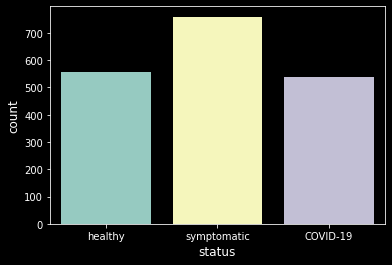

In [ ]:
sns.countplot(data=expert_df, x='status')

#### Our Reasoning for setting the threshold of cough_detection >= 0.8:

According to Orlandic et al., "the ROC curve of the cough classifier is displayed below, which users of the COUGHVID database can consult to set a cough detection threshold that suits their specifications. As this figure shows, only 10.4% of recordings with a cough_detected value less than 0.8 actually contain cough sounds. Therefore, they should be used only for robustness assessment, and not as valid cough examples."


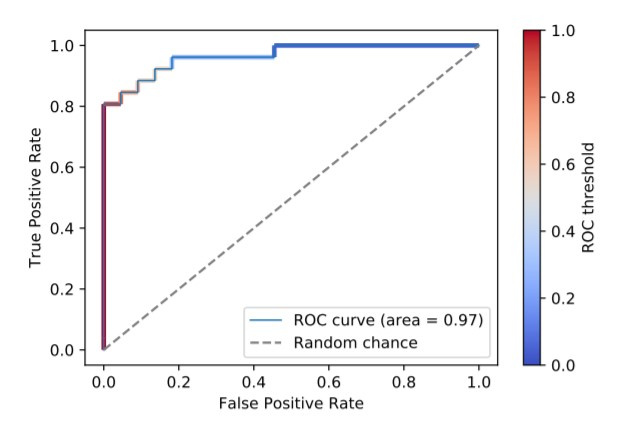

MUST CITE THIS PROPERLY!!
Figure from: L. Orlandic, T. Teijeiro, D. Atienza, The coughvid crowdsourcing
dataset: A corpus for the study of large-scale cough analysis algorithms, arXiv preprint arXiv:2009.11644 (2020)

In [ ]:
# Setting the threshold of cough detection needing to be 80% or greater
cough_df = coughvid_df[coughvid_df['cough_detected'] >= 0.8]

In [ ]:
# We've cut our dataset in half, but since we are focused on training a model to 
# detect COVID-19 through coughing audio, we must make sure that we feed it the 
# audio that actually contains coughing.

len(cough_df)

10746

In [ ]:
# Making sure there are no duplicates in our UUID column
cough_df['uuid'].nunique()

10746

The values within the 'status' column:

The patient self-reports that have been diagnosed with COVID-19 (COVID), that has symptoms but no diagnosis (symptomatic), or that is healthy (healthy).


In [ ]:
# Inspecting counts of each value in 'status' column
cough_df['status'].value_counts()

healthy        5628
symptomatic    1135
COVID-19        547
Name: status, dtype: int64

In [ ]:
# Inspecting count of null values within our 'status' column
cough_df['status'].isna().sum()

3436

In [ ]:
# Since our target variable is the 'status' column, wouldn't it make sense for us
# to remove any null values from this column?

In [ ]:
# Checking the quality of the coughing audio labeled by each expert
quality_check = ['quality_1', 'quality_2', 'quality_3']
for col in quality_check:
  print(f"{cough_df[col].value_counts()}\n")


ok          504
poor        127
good         30
no_cough      7
Name: quality_1, dtype: int64

good        391
ok          229
poor         52
no_cough      6
Name: quality_2, dtype: int64

good        625
ok           21
poor          9
no_cough      8
Name: quality_3, dtype: int64



#### Breaking down the DataFrame into [healthy, COVID] sub dfs

In [ ]:
# dataframe containing all information for those diagnosed as 'healthy'
healthy_df = cough_df[cough_df['status'] == 'healthy']

In [ ]:
# dataframe containing all information for those diagnosed as having 'COVID-19'
covid_df = cough_df[cough_df['status'] == 'COVID-19']

In [ ]:
# Defining a function to remove any rows where quality of the audio indicates 
# there is no cough present in the audio according the to expert pulmonologists

def quality_scrub(df, target_cols = ['quality_1', 'quality_2', 'quality_3']):
  for col in target_cols:
    df = df[df[col] != 'no_cough']
  return df

In [ ]:
# Our cleaned version of the covid_df and the healthy_df
new_covid_df = quality_scrub(covid_df)
new_healthy_df = quality_scrub(healthy_df)

In [ ]:
# Viewing the number of rows that were dropped in the covid_df
print(f"Comparing scrubbed covid df length to original:"
      f"Original: {len(covid_df)}, Scrubbed: {len(new_covid_df)}\n"
      f"Comparing scrubbed healthy df to original:"
      f"Original: {len(healthy_df)}, Scrubbed: {len(new_healthy_df)}")

Comparing scrubbed covid df length to original:Original: 547, Scrubbed: 539
Comparing scrubbed healthy df to original:Original: 5628, Scrubbed: 5626


### Moving all audio files into new directory

Since the unzipped public dataset not only contains our desired audio files, but also related .json files and a .csv file, we are going to move the audio files into a new directory so we don't have to worry about any other files while working with the audio files.

In [ ]:
start = time.time()

# Copying files from /public_dataset and adding them to /public_audio_dataset
shutil.copytree('/public_dataset', '/public_dataset_audio', 
                # Ignoring any csv and json files
                ignore = shutil.ignore_patterns('*.csv', '*.json'))

end = time.time()
time_count(start, end)

Time to run cell: 2 seconds


In [ ]:
# Making sure we have copied the correct number of files 
# Should be the same number as our coughvid_df 
print(len(os.listdir('public_dataset_audio')))
len(os.listdir('public_dataset_audio')) == len(coughvid_df)

20072


True

In [ ]:
# Making sure all files brought over from the public dataset are either webm or
# ogg files. Viewing proportions of each file type

filetype_dict = {'webm': 0, 'ogg': 0}
for item in os.listdir('public_dataset_audio'):
  item_type = item[-4:]
  if 'webm' in item_type:
    filetype_dict['webm'] += 1
  if 'ogg' in item_type:
    filetype_dict['ogg'] += 1
print(filetype_dict)

{'webm': 19213, 'ogg': 859}


In [ ]:
os.listdir('/public_dataset_audio')[0]

'35f7d5fb-2834-4ff4-9b99-2f1eacd5630d.webm'

### Separating healthy and covid audio via separate directories

Putting all public_dataset covid audio files into separate directory

In [ ]:
# Remember that this is the scrubbed version of our covid patients
len(new_covid_df)

539

In [ ]:
def move_audio_files(df, target_col, source, dest, filetypes=['.webm', '.ogg']):
  start = time.time()
  # Creating new destination
  os.makedirs(dest, exist_ok=True) 
  # For each item in our target column: 
  for uuid in df[target_col]:
    # the source id equals the source variable + the item
    src = source + uuid
    try:
      # try to copy the file to the destination if it is a .webm file
      shutil.copy(src=src + filetypes[0], dst=dest)
    except:
      # If that doesn't work
      try:
        # Try to copy the file to the destination if it is an .ogg file
        shutil.copy(src=src + filetypes[1], dst=dest)
      except:
        # If that doesn't work, skip it and continue
        continue
  end = time.time()
  time_count(start, end)

In [ ]:
# Moving our 'pos' case audio files into '/cv_audio/pos/'
move_audio_files(df=new_covid_df, target_col='uuid', source='/public_dataset_audio/', 
                dest='/cv_audio/pos/')

Time to run cell: 0 seconds


In [ ]:
# Checking to make sure we have the same length as our dataframe
print(len(new_covid_df) == len(os.listdir('/cv_audio/pos')))
# Printing the amount of audio files in our newly created folder
print(f"Amount of audio in 'pos' subfolder: {len(os.listdir('/cv_audio/pos'))}")

True
Amount of audio in 'pos' subfolder: 539


Putting all public_dataset healthy audio files into separate directory

In [ ]:
move_audio_files(df=new_healthy_df, target_col='uuid', source='/public_dataset_audio/', 
                 dest='/cv_audio/neg')

Time to run cell: 0 seconds


In [ ]:
print(len(new_healthy_df) == len(os.listdir('/cv_audio/neg')))
# Printing the amount of audio files in our newly created folder
print(f"Amount of audio in 'neg' subfolder: {len(os.listdir('/cv_audio/neg'))}")

True
Amount of audio in 'neg' subfolder: 5626


### Finding Duration for audio files

In [ ]:
# We only need to run this cell once. We then save the duration_list as a dataframe, 
# and store it into our google drive so we can access it later instead of waiting
# 7000 seconds for this cell to run each time.
run = 0
if run:  
  # Finding the duration of all our coughvid 'pos' audio files
  # Creating an empty list to hold the duration of each file
  duration_list = []
  start = time.time()

  # Our target folders
  audio_dir = ['/cv_audio/pos/', '/cv_audio/neg/']
  for folder in audio_dir:
      
    # for each audio file in our target folder:
    for item in os.listdir(folder):

      try:
        # loading the item using librosa if it can load
        y, sr = librosa.load(folder + item)
        # setting the variable audio_time and giving it the duration of the file
        audio_time = librosa.get_duration(y, sr)
        # appending the audio_time variable to our list
        duration_list.append(audio_time)
      except:
        # Adding 0 if we can't extract the duration. We should not get any zeros
        duration_list.append(0)

  end = time.time()
  time_count(start, end)

Time to run cell: 7077 secconds


In [ ]:
# Saving the duration_list as a dataframe

#tot_duration_df = pd.Series(duration_list, name='duration').to_frame()

In [ ]:
# os.makedirs('/content/drive/MyDrive/gdrive/capstone/created_dfs', exist_ok=True)

In [ ]:
# Save the dataframe as a csv so we can use it later instead of wait to run again
# tot_duration_df.to_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/duration.csv')

In [ ]:
# We've ran the above functioning cell and sved it in our google drive so we can
# load it in instead of running the cell above every time we want to view the data
duration_df = pd.read_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/duration.csv')

In [ ]:
len(duration_df)

6165

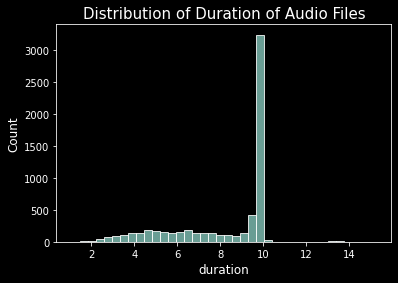

In [ ]:
sns.histplot(duration_df, x='duration')
plt.title('Distribution of Duration of Audio Files');

In [ ]:
duration_df['duration'].describe()

count    6165.000000
mean        8.228697
std         2.307223
min         1.080000
25%         6.480000
50%         9.720000
75%         9.900000
max        15.240000
Name: duration, dtype: float64

In [ ]:
# The 99th percentile in terms of duration is 10.02 seconds
duration_df.quantile(0.99)

Unnamed: 0    6102.36
duration        10.02
Name: 0.99, dtype: float64

In [ ]:
# There are 50 audio files that are greater than 10.02 seconds
len(duration_df[duration_df['duration'] > 10.02])

50

In [ ]:
# If we were to set a filter that did not use audio files greater than 10.02, 
# we would be removing 0.8% of our targeted data
print(f"{round((50/6165) * 100, 2)}%")

0.81%


### Converting .webm audio to .ogg audio

webm files are actually video files. In order for us to be able to extract the audio from these files, we need to find a library that can help us do so.

---



Creating new ogg audio files

In [ ]:
# root_dir = '/cv_audio/neg/'
# new_dir = '/cleaned_audio/neg/'

# os.makedirs(new_dir, exist_ok=True)
# for audio in os.listdir(root_dir)[:10]:
#   extension = os.path.splitext(audio)[-1].lower()
#   print(audio)
#   if extension == '.webm':
#     audio_name = os.path.splitext(audio)[0]
#     input = f"ffmpeg -i {root_dir + audio_name}.webm {new_dir + audio_name}.ogg"
#     os.system(input)
#   else:
#     shutil.copy(src=root_dir + audio, dst=new_dir)

    

In [ ]:
# Defining our current directories for positive and negative files and 
# Creating new directories to store the converted positive and negative files
root_dir_neg = '/cv_audio/neg/'
new_dir_neg = '/cleaned_audio/neg/'
root_dir_pos = '/cv_audio/pos/'
new_dir_pos = '/cleaned_audio/pos/'

def convert_audio(root_dir, new_dir):
  """
  Definition:
  For every item in the root directory, this func identifies the type of audio 
  file. If the audio file is a .webm file, the function uses the library ffmpeg
  to change the file type into an .ogg file and transfers that new file into 
  the new specified directory.

  Args:
  root_dir: Required. Declare the directory that holds the targeted files you wish
  to convert.
  new_dir: Required. Declare the new directory you wish to store the converted
  files. Does not have to exist beforehand.

  Returns:
  Creates the new directory, stores the converted files, and prints the amount 
  of time it took to run the function.
  """
  start = time.time()

  os.makedirs(new_dir, exist_ok=True)
  for audio in os.listdir(root_dir):
    extension = os.path.splitext(audio)[-1].lower()
    if extension == '.webm':
      audio_name = os.path.splitext(audio)[0]
      input = f"ffmpeg -i {root_dir + audio_name}.webm {new_dir + audio_name}.ogg"
      os.system(input)
    else:
      shutil.copy(src=root_dir+audio, dst=new_dir)

  end = time.time()
  time_count(start, end)    

Converting all webm audio files into ogg files

In [ ]:
# Converting any webm files in the '/cv_audio/pos/' directory into ogg files
# and moving all files into a new directory
root_dir_pos = '/cv_audio/pos/'
new_dir_pos = '/cleaned_audio/pos/'

convert_audio(root_dir_pos, new_dir_pos)

Time to run cell: 222 seconds


In [ ]:
# Confirming that the amount of audio files is the same in the new directory
# as the old directory 
len(os.listdir(root_dir_pos)) == len(os.listdir(new_dir_pos))

True

In [ ]:
# Converting any webm files in the '/cv_audio/neg/' directory into ogg files
# and moving all files into a new directory
root_dir_neg = '/cv_audio/neg/'
new_dir_neg = '/cleaned_audio/neg/'

convert_audio(root_dir_neg, new_dir_neg)

Time to run cell: 2214 seconds


In [ ]:
# Confirming that the amount of audio files is the same in the new directory
# as the old directory 
len(os.listdir(root_dir_neg)) == len(os.listdir(new_dir_neg))

True

In [ ]:
run=0
if run:
  shutil.copytree('/cleaned_audio/', 
                '/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_audio/')

'/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_audio/'

In [ ]:
new_rd = '/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_audio/'
for folder in os.listdir(new_rd):
  print(len(os.listdir(new_rd + folder)))

539
5626


In [ ]:
signal, sr = librosa.load('/cleaned_audio/pos/015576c8-2b03-4dcb-b251-78a984fe86fe.ogg')
ipd.Audio(signal, rate=sr)

In [ ]:
def get_audio_duration(root_dir):
  """
  Definition:
  Finds the duration of each audio file in a folder, uses the librosa library to
  get the time duration for each file, and appends each duration to a list called 
  duration_list. This list is then transformed into a dataframe, and then returned
  and the function output.

  Args:
  root_dir: Required. Specify the folder that holds the audio files.

  Returns:
  A dataframe that holds the duration for each audio file and prints the amount
  of time it took to run the function.
  """
  
  duration_list = []
  start = time.time()
  for item in os.listdir(root_dir):
    try:
      # loading the item using librosa if it can load
      y, sr = librosa.load(root_dir + item)
      # setting the variable audio_time and giving it the duration of the file
      audio_time = librosa.get_duration(y, sr)
      # appending the audio_time variable to our list
      duration_list.append(audio_time)
    except:
      # Adding 0 if we can't extract the duration. We should not get any zeros
      duration_list.append(0)

  df = pd.Series(duration_list, name='duration').to_frame()

  end = time.time()
  time_count(start, end)
  return df

In [ ]:
cleaned_duration_df = get_audio_duration('/cleaned_audio/pos/')

In [ ]:
cleaned_duration_df['duration'].describe()

count    539.000000
mean       8.407524
std        2.324254
min        1.094694
25%        7.066599
50%        9.781361
75%        9.857370
max       13.089342
Name: duration, dtype: float64

Here we can see that the duration for all our our audio in the '/cleaned_audio/pos/' folder is not uniform. Just like images, we need to feed the model the same shape for audio files as well. To do this, we must add silence to audio files that are less than 10.02 seconds (our 99th percentile) and make them all 10.02 seconds long. After that, we may then proceed to make spectrogram images from each audio file once they are all the correct length. 

### Adding Silent length to Cleaned CV audio

Adding silent length to our audio files less than our max_duration (defined below) in the '/cleaned_audio/pos' folder

In [ ]:
# This cell works correctly, attempting to make a function out of it

start = time.time()

# Setting a limit for maximum duration - this is our 99th percentile
max_duration = 10.02
# Defining our target folder to pull audio from
clean_rd = '/cleaned_audio/pos/'

for audio in os.listdir(clean_rd):
  address = clean_rd + audio
  sig, sr = librosa.load(address)
  dur = librosa.get_duration(sig, sr=sr)
  if dur <= max_duration: 
    # Defining the amount of silence for each audio file
    silent_length = (10.02*1000) - (dur*1000)
    silent_int = int(silent_length)

    # creating 8.4 secs of audio silence -- duration in milliseconds
    silent_segment = AudioSegment.silent(duration=silent_int)

    #read our target wav file example to an audio segment
    cough_audio = AudioSegment.from_ogg(address)

    # Combining our silent segment with the audio example
    extended_cough = cough_audio + silent_segment

    # making a folder to hold our extended audio example
    os.makedirs('/ext_audio/pos/', exist_ok=True)
    output = f'/ext_audio/pos/{audio}' 
    #print(f"{output}\n")
    extended_cough.export(out_f=output)
  else: 
    continue

end = time.time()
time_count(start, end)

Time to run cell: 921 seconds


In [ ]:
def create_silence(root_dir, new_dir, max_dur=10.02):
  start = time.time()

  for audio in os.listdir(root_dir):
    address = root_dir + audio
    sig, sr = librosa.load(address)
    dur = librosa.get_duration(sig, sr=sr)
    if dur <= max_dur: 
      # Defining the amount of silence for each audio file
      silent_length = (max_dur*1000) - (dur*1000)
      silent_int = int(silent_length)

      # creating 8.4 secs of audio silence -- duration in milliseconds
      silent_segment = AudioSegment.silent(duration=silent_int)

      # Finding the extension for each file
      extension = os.path.splitext(audio)[-1].lower()

      if extension == '.mp3':
        cough_audio = AudioSegment.from_mp3(address)

      elif extension == '.ogg':
        cough_audio = AudioSegment.from_ogg(address)

      # Combining our silent segment with the audio example
      extended_cough = cough_audio + silent_segment

      # making a folder to hold our extended audio example
      os.makedirs(new_dir, exist_ok=True)
      output = f'{new_dir + audio}' 
      #print(f"{output}\n")
      extended_cough.export(out_f=output)
    else: 
      continue

  end = time.time()
  time_count(start, end)

In [ ]:
# def create_silence(root_dir, new_dir, max_dur=10.02):
#   start = time.time()

#   for audio in os.listdir(root_dir):
#     address = root_dir + audio
#     sig, sr = librosa.load(address)
#     dur = librosa.get_duration(sig, sr=sr)

#     if dur == max_dur:
#       # making a folder to hold our extended audio example
#       os.makedirs(new_dir, exist_ok=True)
#       output = f'{new_dir + audio}' 
#       #print(f"{output}\n")
#       shutil.copyfile(address, output)

#     elif dur < max_dur: # Changed from dur <= max_dur
#       # Defining the amount of silence for each audio file
#       silent_length = (max_dur*1000) - (dur*1000)
#       silent_int = int(silent_length)

#       # creating audio silence -- duration in milliseconds
#       silent_segment = AudioSegment.silent(duration=silent_int)

#       # Finding the extension for each file
#       extension = os.path.splitext(audio)[-1].lower()

#       if extension == '.mp3':
#         cough_audio = AudioSegment.from_mp3(address)

#       elif extension == '.ogg':
#         cough_audio = AudioSegment.from_ogg(address)

#       # Combining our silent segment with the audio example
#       extended_cough = cough_audio + silent_segment

#       # making a folder to hold our extended audio example
#       os.makedirs(new_dir, exist_ok=True)
#       output = f'{new_dir + audio}' 
#       #print(f"{output}\n")
#       extended_cough.export(out_f=output)
#     else: 
#       continue

#   end = time.time()
#   time_count(start, end)

### Extending length of virufy audio

Extending all audio in virufy 'pos/' subfolder

In [ ]:
# Testing on virufy data
create_silence(root_dir='/virufy_data-main/clinical/segmented/pos/', 
               new_dir='/ext_audio_virufy/pos/')

Time to run cell: 47 seconds


In [ ]:
virufy_pos_df = get_audio_duration('/ext_audio_virufy/pos/')
virufy_pos_df['duration'].describe()

Time to run cell: 42 seconds


count    48.000000
mean     10.019770
std       0.000024
min      10.019728
25%      10.019773
50%      10.019773
75%      10.019773
max      10.019819
Name: duration, dtype: float64

Extending all audio in virufy 'neg/' subfolder

In [ ]:
create_silence(root_dir='/virufy_data-main/clinical/segmented/neg/', 
               new_dir='/ext_audio_virufy/neg/')

Time to run cell: 71 seconds


In [ ]:
virufy_neg_df = get_audio_duration('/ext_audio_virufy/neg/')
virufy_neg_df['duration'].describe()

Time to run cell: 64 seconds


count    73.000000
mean     10.019769
std       0.000023
min      10.019728
25%      10.019773
50%      10.019773
75%      10.019773
max      10.019819
Name: duration, dtype: float64

 Creating new silenced audio files from our '/cleaned_audio/neg' folder!


In [ ]:
# Sending extended audio to our new_dir
create_silence(root_dir='/cleaned_audio/neg/', new_dir='/ext_audio/neg/')

Time to run cell: 7730 seconds


In [ ]:
# Checking the number of files in our folder
len(os.listdir('/ext_audio/neg/'))

5551

In [ ]:
# Sending extended audio to our new_dir
create_silence(root_dir='/cleaned_audio/pos/', new_dir='/ext_audio/pos/')

Time to run cell: 747 seconds


In [ ]:
len(os.listdir('/ext_audio/pos/'))

533

In [ ]:
# Identifying the number of extended audio files we have so far
len(os.listdir('/ext_audio/neg/')) + len(os.listdir('/ext_audio/pos/'))

6084

In [ ]:
# Copying all of our created files so we don't have to take 3 hours to create 
# them again. Note that these files are only the files from our coughvid dataset, 
# We have not combined the virufy audio data yet.
run = 0
if run: 
  shutil.copytree('/ext_audio/', 
                '/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/')

In [ ]:
# Checking the duration in our negative audio files that we've saved
neg_dur_df = get_audio_duration('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/neg/')

Time to run cell: 7651 seconds


In [ ]:
(len(os.listdir('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/neg')) + 
len(os.listdir('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/pos')))

6084

### Combining our virufy extended audio to our coughvid audio

In [ ]:
virufy_base = '/ext_audio_virufy/'
for folder in os.listdir(virufy_base):
  print(len(os.listdir(virufy_base + folder)))

73
48


In [ ]:
# This is the number we expect to see in our saved audio files after combining
# the datasets
expected_number_files = 6084 + 73 + 48

6205

In [ ]:
# Joining virufy audio with coughvid audio in our permanent folder
run=0
if run:
  virufy_base = '/ext_audio_virufy/'
  new_base = '/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/'

  for folder in os.listdir(virufy_base):
    virufy_address = virufy_base + folder + '/'
    new_address = new_base + folder + '/'

    for audio in os.listdir(virufy_address):
      audio_file = virufy_address + audio
      shutil.move(audio_file, new_address)

In [ ]:
(len(os.listdir('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/neg')) + 
len(os.listdir('/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/pos')))

6205

### Extended Audio Playground

Inspecting the newly extended audio

In [ ]:
# Negative audio example
neg_root_dir = '/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/neg/'
audio_ext_ex = os.listdir(neg_root_dir)[0]

neg_signal, sr = librosa.load(neg_root_dir + audio_ext_ex)

In [ ]:
# Editing our to_mel_spectro() func

def to_mel_spectro(signal, sr, hop_length, n_fft, n_mels=128, cmap='magma', 
                    ref=1, figsize=(10, 4), hide=1, fmax=None):
  """
  Definition:
  Plots a mel-spectrogram of a signal.

  Args:
  signal: Required. An audio time series, usually an numpy 1 dimensional array.
  sr: Required. The sample rate of the signal.
  hop_length: Required. The amount to shift each fast fourier transform.
  n_fft: Required. The number of samples in a window per fast fourier transform.
  cmap: default = 'magma'. The color palette of the spectrogram.
  ref: default = np.max. Tells the librosa.power_to_db() how to scale the values.
  When ref=np.max, it will make the highest value 0, and everything else will be 
  lower than it, respectively so. Does not change the color distribution of the
  spectrogram.
  figsize: default = (10, 4). A tuple representing the desired figure size for 
  the plot.
  hide: default = 1. If true, hides the x and y axes along with the plot frame.
  fmax: default = None. Sets the limit of the melspectrogram y-axis.

  Returns:
  Plots a spectrogram via librosa.display.specshow()
  """

  mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, 
                                              n_fft=n_fft, n_mels=n_mels, fmax=fmax)
  #spectrogram = np.abs(mel_signal)
  power_to_db = librosa.core.power_to_db(mel_signal, ref=ref)#spectrogram, ref=ref)
  # Creating figure
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111)
  # Hiding axes and image frame
  if hide:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

  ldp.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap=cmap, 
              hop_length=hop_length, fmax=fmax)
  #plt.colorbar(label='dB')
  plt.show()

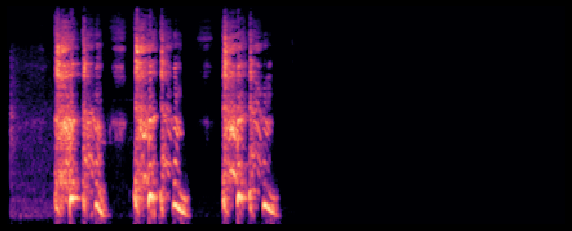

In [ ]:
to_mel_spectro(neg_signal, sr, hop_length=512, n_fft=2048, figsize=(10, 4), 
                ref=1, cmap='magma', hide=1)

### Creating and saving mel-spectrograms

In [ ]:
def create_save_spectros(root_dir, new_dir, hop_length, n_fft, sr=22050,
                         fmax=9000, ref=1, figsize=(10, 4), cmap='magma', 
                         dpi=400):
  """
  Definition:
  Takes the address defined by the variable 'root_dir' and goes through each class
  folder within that directory. For each audio file in a class directory, the 
  librosa library loads the audio file into signal and sample rate variables, then 
  plots the mel-spectrogram. We then save the spectrogram into the address of the 
  'new_dir' folder using the same end name of the audio's original address, and 
  shuts down the figure.

  Args:
  root_dir: Required. The address containing subfolders of classes and audio 
  files within those folders.
  new_dir: Required. The address you wish to save the mel-spectrograms.
  hop_length: Required. The number of samples between successive frames - 
  (e.g. the columns of a spectrogram)
  n_fft: Required. The (positive integer) number of samples in an analysis 
  window (or frame). Should be larger than hop_length.
  sr: default = 22050. The (positive integer) number of samples per second of a 
  time series.
  fmax: default = 9000. Highest frequency (in Hz).
  ref: default = 1. If scalar, the amplitude abs(S) is scaled relative to 'ref'.
  figsize: default = (10, 4). The size of the plotted spectrogram.
  cmap: default = 'magma'. The color palette of the spectrogram.
  dpi: default = 400. The resolution in dots per inch - higher values result in
  higher quality images.

  Returns:
  The time it took to run the function in seconds.
  """
  start = time.time()
  #making sure we add a forward slash to our root_dir and new_dir variables
  if root_dir[-1] != '/':
    root_dir = root_dir + '/'
  if new_dir[-1] != '/':
    new_dir = new_dir + '/'

  # For each subfolder in our root directory:
  for status in os.listdir(root_dir):
    #print(status)

    # Create a new variable called subfolder
    subfolder = root_dir + status
    #print(subfolder)

    # For each audio file in our subfolder, load into signal and sample rate vars
    for audiofile in os.listdir(subfolder):
      signal, sr = librosa.load(subfolder + '/' + audiofile, sr=sr)

      plt.interactive(False)

      # Creating a melspectrogram
      mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, 
                                                  hop_length=hop_length, 
                                                  n_fft=n_fft, fmax=fmax)
      
      # Converting the power in the ndarray of our mel_signal into decibels
      power_to_db = librosa.power_to_db(mel_signal, ref=ref)
      # Creating figure
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
      # Hiding axes and image frame
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
      ax.set_frame_on(False)

      # Displaying our spectrograms
      ldp.specshow(power_to_db, sr=sr, cmap=cmap, hop_length=hop_length)
      
      # making folder to store images
      new_subfolder = new_dir + status + '/'
      os.makedirs(new_subfolder, exist_ok=True)

      #print(new_subfolder)

      # Saving each spectrogram into its respective folder
      # subfile[:-4] is a string of the subfile without the ending extension '.mp3'
      # We add the '.png' extension to the end of our new spectrogram images instead
      plt.savefig(fname=new_subfolder + audiofile[:-4] + '.png', dpi=dpi, 
                  bbox_inches='tight',pad_inches=0)
      
      # We then manually close pyplot, clear the figure, close the fig variable, 
      # and then close the figure window
      plt.close()    
      fig.clf()
      plt.close(fig)
      plt.close('all')

  # Display the time it took to run the cell in seconds
  end = time.time()
  time_count(start, end)

Creating our audio spectrograms!

In [ ]:
run=0
if run:
  audio_dir = '/content/drive/MyDrive/gdrive/capstone/audio_folders/ext_audio/'
  spec_dir = '/content/drive/MyDrive/gdrive/capstone/spectrograms/'

  create_save_spectros(root_dir=audio_dir, new_dir=spec_dir, hop_length=512, 
                      n_fft=2048, fmax=9000, ref=np.max, figsize=(10, 4))

Time to run cell: 20298 seconds


(1208, 3100)


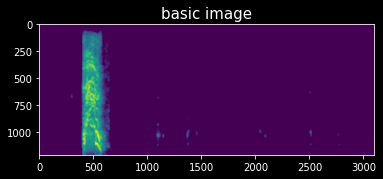

In [ ]:
# Viewing a saved spectrogram and it's dimensions
spec_root = '/content/drive/MyDrive/gdrive/capstone/spectrograms/pos/'
spec_ex = os.listdir('/content/drive/MyDrive/gdrive/capstone/spectrograms/pos/')[0]
img = cv2.imread(spec_root + spec_ex, 0)

print(img.shape)
plt.title('basic image')
plt.imshow(img)

(200, 500, 3)


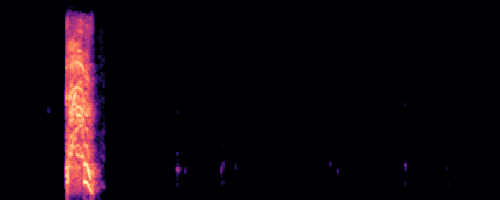

In [ ]:
# Note that we can change the size of our images
img_ex = load_img(spec_root + spec_ex, target_size=(200, 500))
print(img_to_array(img_ex).shape)
img_ex

In [ ]:
spectro_images = num_items('/content/drive/MyDrive/gdrive/capstone/spectrograms', 
                           targets=['/pos', '/neg'])

/content/drive/MyDrive/gdrive/capstone/spectrograms
Number of items in /pos: 581
Number of items in /neg: 5624
Total number of items: 6205


## Preparing Image Data Generators

### Creating train, test, and val folders

In [ ]:
# Splitting our spectrogram images into train, test, and validation subfolders
# and saving these folders in our google drive so we can access them after we shut
# down our runtime

# We only want to run this once, so we set a variable called run to 0 to prevent
# it from running again by accident.
run = 0
base_folder = '/content/drive/MyDrive/gdrive/capstone/spectrograms'
if run:
  splitfolders.ratio(input=base_folder, 
                    output='/content/drive/MyDrive/gdrive/capstone/spectro_folders', 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio order: train, val, test
else:
  print('Did not run')

Did not run


Using the zipped spectro_folders_zip file from here on to work with

In [119]:
# Unzipping our zipped spectro folder and moving it to the root directory for
# easier access
f_name = '/content/drive/MyDrive/gdrive/capstone/spectro_folders_zip.zip'
with ZipFile(f_name, 'r') as zipf:
      zipf.extractall()
      print('Done')

Done


In [120]:
# Checking to make sure we still have the same number of images
spectro_root_dir = '/spectro_folders'
folder_check(spectro_root_dir, check=0)

/spectro_folders/train/
Number of items in pos: 406
Number of items in neg: 3936
Total number of items: 4342

/spectro_folders/test/
Number of items in pos: 118
Number of items in neg: 1126
Total number of items: 1244

/spectro_folders/val/
Number of items in pos: 57
Number of items in neg: 562
Total number of items: 619


Total image count: 6205


In [121]:
train_folder, test_folder, val_folder = create_ttv(spectro_root_dir)

In [122]:
train_folder

'/spectro_folders/train/'

In [123]:
TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, VAL_BATCH_SIZE = batch_sizes(folder_list=[train_folder, 
                                                                             test_folder, 
                                                                             val_folder])
print(f"Train batch size: {TRAIN_BATCH_SIZE}\nTest batch size: {TEST_BATCH_SIZE}\n"
      f"Validation batch size: {VAL_BATCH_SIZE}")
IMG_SIZE = (200, 500)

Train batch size: 4342
Test batch size: 1244
Validation batch size: 619


In [124]:
spectro_datagen = ImageDataGenerator(rescale=1./255)

train_spectro_gen = spectro_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=TRAIN_BATCH_SIZE,
                                                   class_mode='binary')

test_spectro_gen = spectro_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=TEST_BATCH_SIZE,
                                                     class_mode='binary')

val_spectro_gen = spectro_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=VAL_BATCH_SIZE,
                                                    class_mode='binary')

Found 4342 images belonging to 2 classes.
Found 1244 images belonging to 2 classes.
Found 619 images belonging to 2 classes.


In [125]:
# This augmentation will be used on our training data
aug_spectro_datagen = ImageDataGenerator(width_shift_range=0.1, 
                                         brightness_range=(0.9, 1.3), 
                                         zoom_range=0.1)

In [129]:
# Viewing classes
train_spectro_gen.class_indices

{'neg': 0, 'pos': 1}

In [130]:
# Viewing the shape
train_spectro_gen.image_shape

(200, 500, 3)

In [119]:
def create_sets(generator):
  start = time.time()
  # Creating X and y values for train set
  X, y = next(generator)
  end = time.time()
  time_count(start, end)
  return X, y

If the image sizes are too large, the below three lines will crash the runtime.

In [132]:
# # Creating X and y values for train set
X_train, y_train = create_sets(train_spectro_gen)

Time to run cell: 233 seconds


In [133]:
# Creating X and y values for test set
X_test, y_test = create_sets(test_spectro_gen)

Time to run cell: 66 seconds


In [134]:
# Creating X and y values for val set
X_val, y_val = create_sets(val_spectro_gen)

Time to run cell: 33 seconds


In [135]:
# Viewing the spectrograms image shape
INPUT_SHAPE = X_train.shape[1:]
print(INPUT_SHAPE)

(200, 500, 3)


Class 0.0


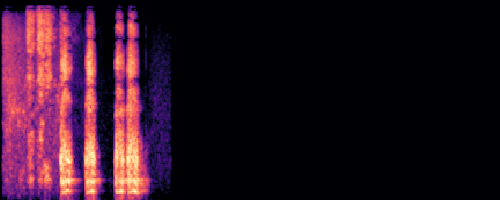

In [136]:
random_image(X_train, y_train)

In [137]:
class_weights_dict = make_class_weights(y_train)

Our class weights:
{0: 0.5515752032520326, 1: 5.347290640394089}


In [188]:
# Our classes are extremey unbalanced
class_weights_dict

{0: 0.5515752032520326, 1: 5.347290640394089}

### Creating a basic model for spectrograms

In [166]:
def basic_spectro_model(shape='', opt=tf.keras.optimizers.Adam(), 
                        metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall'), 
                                        tf.keras.metrics.AUC(name='auc')],
                        loss=tfa.losses.SigmoidFocalCrossEntropy(), 
                        verbose=1):
  """
  Definition:
  Creates and compiles a neural network model. 

  Args:
  shape: default = ''. The input shape of the images to be passed in to the 
  neural network. The size must be the same as the images being passed in.
  metrics: default = ['acc', tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall'), 
                             tf.keras.metrics.AUC(name='auc')].
           The metrics that are to be analyzed and plotted from the 
           training of the model.
  verbose: default = 1. If 1, prints a summary of the model upon compilation.

  Returns:
  The model, along with the model.summary() if verbose = 1.
  """
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(256, activation='relu'))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
    print(model.summary())
    return model

In [150]:
spectro_model1 = basic_spectro_model(shape=INPUT_SHAPE)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 198, 498, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 99, 249, 32)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 97, 247, 64)       18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 48, 123, 64)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 46, 121, 128)      73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 23, 60, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 21, 58, 256)      

Epoch 1/25
136/136 [==============================] - 93s 676ms/step - loss: 30.0233 - acc: 0.5497 - precision: 0.1015 - recall: 0.4824 - auc: 0.5117 - val_loss: 0.7061 - val_acc: 0.0921 - val_precision: 0.0921 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/25
136/136 [==============================] - 90s 665ms/step - loss: 0.6825 - acc: 0.4600 - precision: 0.0959 - recall: 0.5884 - auc: 0.5409 - val_loss: 0.7067 - val_acc: 0.0921 - val_precision: 0.0921 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/25
136/136 [==============================] - 91s 667ms/step - loss: 0.7031 - acc: 0.3735 - precision: 0.1081 - recall: 0.7127 - auc: 0.5055 - val_loss: 0.6942 - val_acc: 0.0921 - val_precision: 0.0921 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/25
136/136 [==============================] - 90s 659ms/step - loss: 0.7033 - acc: 0.4056 - precision: 0.1044 - recall: 0.6750 - auc: 0.5144 - val_loss: 0.7124 - val_acc: 0.0921 - val_precision: 0.0921 - val_recall: 1.0000 - val_auc: 0.5000
Epo

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


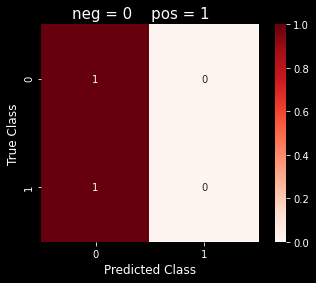

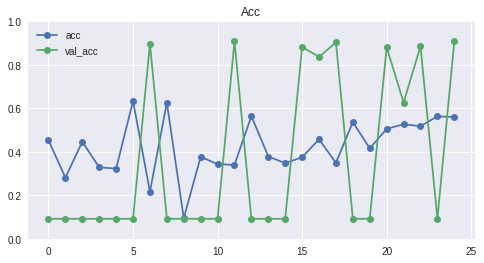

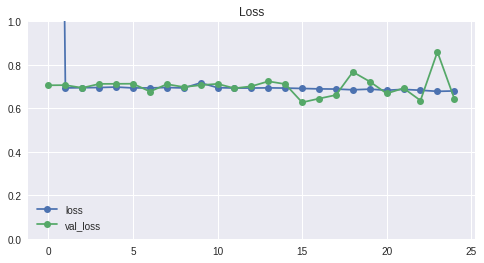

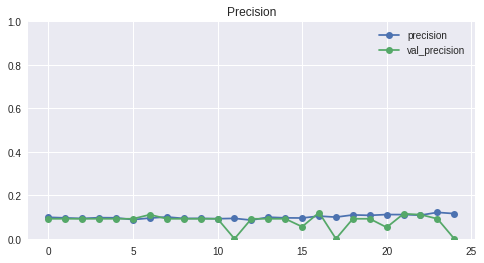

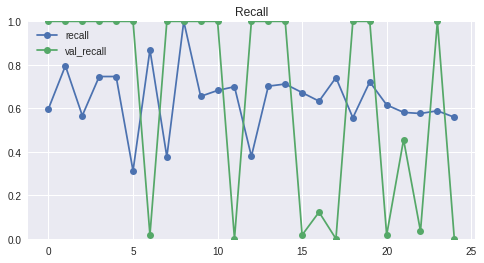

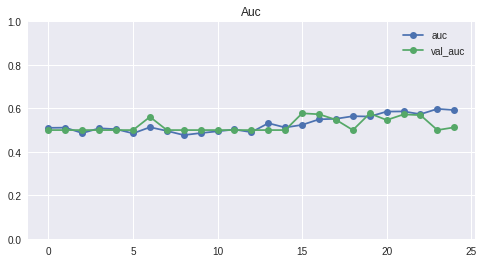

------------------------------------------------------------
39/39 [==============================] - 1s 26ms/step - loss: 0.6447 - acc: 0.9051 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
loss score: 0.6446995735168457
accuracy score: 0.9051446914672852
precision score: 0.0
recall score: 0.0
auc score: 0.4999698996543884

Time to run cell: 2268 seconds


In [151]:
spectro_hist = fit_plot_report(spectro_model1, X_train, y_train, X_val, y_val, X_test, 
                               y_test, aug_spectro_datagen, class_weights=class_weights_dict, 
                               class_indices=train_spectro_gen.class_indices, epochs=25, 
                               class_type='binary', batch_size=32)

Our model is struggling with identifying the different classes due to the unbalance between the two.

### Oversampling with Image Augmentation Manipulation

In [125]:
# We are going to create augmented images from our training folder's minority
# class and save them into a new directory
train_folder = '/spectro_folders/train/'
train_minority_folder = train_folder + 'pos/'
train_majority_folder = train_folder + 'neg/'

#Viewing the number of images in our majority class of the training folder
print(f"Number of images in majority class: {len(os.listdir(train_majority_folder))}\n"
      f"Number of images in minority class: {len(os.listdir(train_minority_folder))}")

Number of images in majority class: 3936
Number of images in minority class: 406


### Test Area - Creating a copy of spectro_folder and removing all majority class images

In [126]:
# copying the train folder
shutil.copytree(train_folder, '/train_copy/')

'/train_copy/'

In [127]:
# Verifying that the amount of images in the copied folder is the same as the 
# original folder
num_items('/train_copy/', targets=['pos/', 'neg/'])

/train_copy/
Number of items in pos/: 406
Number of items in neg/: 3936
Total number of items: 4342


4342

In [128]:
# removing all negative images within the copied train folder
shutil.rmtree('/train_copy/neg/')
# recreating the 'neg/' subfolder in our copied train folder
os.makedirs('/train_copy/neg/')

In [129]:
# Verifying that we have removed all images in the negative folder
num_items('/train_copy/', targets=['pos/', 'neg/'])

/train_copy/
Number of items in pos/: 406
Number of items in neg/: 0
Total number of items: 406


406

#### Minority Data Generator

In [130]:
# Creating a data generator for the minority class
min_datagen = ImageDataGenerator(rescale=1./255,  
                                 width_shift_range=0.1, 
                                 channel_shift_range=0.2, 
                                 shear_range=0.2, 
                                 brightness_range=[0.75, 1.3])
IMG_SIZE = (200,500)

In [131]:
aug_train_folder = '/train_copy/'

# Making a directory to store the augmented images
aug_dir = '/aug_images/'
os.makedirs(aug_dir, exist_ok=True)

aug_iter = min_datagen.flow_from_directory(aug_train_folder, 
                                           target_size=IMG_SIZE, 
                                           batch_size=406, 
                                           save_to_dir=aug_dir, 
                                           save_prefix='aug', 
                                           shuffle=True)

Found 406 images belonging to 2 classes.


In [132]:
#shutil.rmtree('/aug_images/')

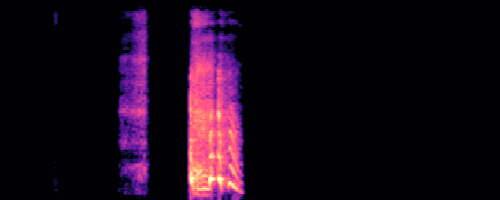

In [227]:
X_train_aug, y_train_aug = next(aug_iter)
array_to_img(X_train_aug[0])

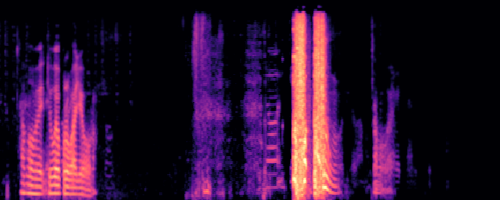

In [228]:
X_train_aug, y_train_aug = next(aug_iter)
array_to_img(X_train_aug[0])

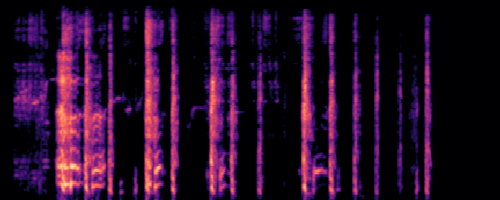

In [229]:
X_train_aug, y_train_aug = next(aug_iter)
array_to_img(X_train_aug[0])

In [133]:
print(f"Difference between classes: "
f"{len(os.listdir(train_majority_folder)) - len(os.listdir(train_minority_folder))}")

Difference between classes: 3530


In [134]:
# Creating 3530 augmentations of our minority class images in our train folder
# Adding these augmentation images to our positive images will balance our classes
start = time.time()

while len(os.listdir('/aug_images/')) < 3530:
  next(aug_iter)

end = time.time()
time_count(start, end)

Time to run cell: 370 seconds


In [135]:
# Viewing the amount of augmented images we've created so far
len(os.listdir(aug_dir))

3654

In [136]:
# Removing random augmented image files from our augmented image folder so the 
# classes will be equal

while len(os.listdir(aug_dir)) > 3530:
  rand_chosen = np.random.choice(os.listdir(aug_dir))
 
  random_path = aug_dir + rand_chosen
  try:
    os.remove(random_path)
  except:
    continue


In [137]:
len(os.listdir(aug_dir))

3530

In [138]:
def display_images(source, amnt_to_display):
  """
  Definition:
  Define the 'source' variable by giving it a filepath containing images along with
  setting the number you wish to view through the variable 'amnt_to_display'. The
  function will plot the selected number of images within the file and display them.

  Args:
  source: Required. A filepath containing images.
  amnt_to_display: Required. The number of images you wish to display.

  Returns:
  Plots a certain amount of images from the selected filepath.
  """
  
  plt.figure(figsize=(20,10))
  cols = amnt_to_display//2
  images = os.listdir(source)[:amnt_to_display]
  for i, img in enumerate(images):
      #Opening each image from its respective filepath
      x_image = Im.open(source+img)
      # defining the position for each subplot 
      # subplot(nrows, ncols, index)
      plt.subplot(len(images) / cols + 1, cols, i + 1)
      #plotting each image in a new subplot
      plt.imshow(x_image)
      # Hiding the x and y axis tick marks
      plt.xticks([])
      plt.yticks([])
      # fitting the images closer together
      plt.tight_layout()

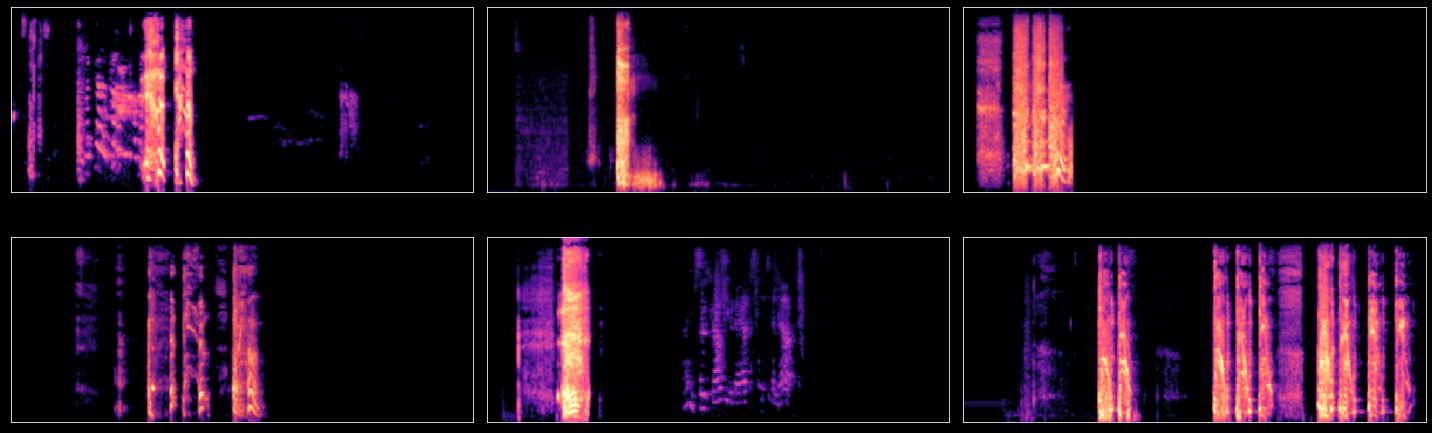

In [139]:
display_images('/aug_images/', amnt_to_display=6)

In [140]:
# Making another copy of our spectrogram folder - we will use this one to model
# with. We are going to add our augmentations into the minority class of the 
# training folder
shutil.copytree('/spectro_folders/', '/spectro_modeling/')

'/spectro_modeling/'

In [141]:
# Viewing the number of images in each class for each subfolder
folder_check('/spectro_modeling')

/spectro_modeling/train/
Number of items in pos: 406
Number of items in neg: 3936
Total number of items: 4342

/spectro_modeling/test/
Number of items in pos: 118
Number of items in neg: 1126
Total number of items: 1244

/spectro_modeling/val/
Number of items in pos: 57
Number of items in neg: 562
Total number of items: 619


Total image count: 6205


In [142]:
# Copying over our augmented images into the training minority class folder ('pos')
for f in os.listdir(aug_dir):
  shutil.copy(aug_dir + f, '/spectro_modeling/train/pos/')

In [143]:
# Sanity check
folder_check('/spectro_modeling')

/spectro_modeling/train/
Number of items in pos: 3936
Number of items in neg: 3936
Total number of items: 7872

/spectro_modeling/test/
Number of items in pos: 118
Number of items in neg: 1126
Total number of items: 1244

/spectro_modeling/val/
Number of items in pos: 57
Number of items in neg: 562
Total number of items: 619


Total image count: 9735


In [167]:
# Creating strings to define the address for each train, test, and val folder
train_spec, test_spec, val_spec = create_ttv('/spectro_modeling')

In [168]:
# Setting batch size and image size
#train_batch, test_batch, val_batch = batch_sizes([train_spec, test_spec, val_spec])
IMG_SIZE = (200, 500)

In [169]:
# Rescaling the images to floats based off of the RGB intensity values (0-255)
# This way, the values will be numbers somewhere between 0 and 1.
spec_gen = ImageDataGenerator(rescale=1./255)

# Creating iterators for train, test, and val sets
train_spec_gen = spec_gen.flow_from_directory(train_spec, 
                                              target_size=IMG_SIZE,
                                              batch_size=32,
                                              class_mode='binary', 
                                              shuffle=True)

test_spec_gen = spec_gen.flow_from_directory(test_spec, 
                                             target_size=IMG_SIZE,
                                             batch_size=32,
                                             class_mode='binary', 
                                             shuffle=False)

val_spec_gen = spec_gen.flow_from_directory(val_spec, 
                                            target_size=IMG_SIZE,
                                            batch_size=32,
                                            class_mode='binary', 
                                            shuffle=True)

Found 7872 images belonging to 2 classes.
Found 1244 images belonging to 2 classes.
Found 619 images belonging to 2 classes.


In [157]:
#X_train, y_train = create_sets(train_spec_gen)

In [158]:
#X_test, y_test = create_sets(test_spec_gen)

In [159]:
#X_val, y_val = create_sets(val_spec_gen)

In [170]:
# Since our class weights should be even, we don't need the class weights for 
# this modeling process
class_weights_dict = make_class_weights(train_spec_gen.classes, classification='binary')

Our class weights:
{0: 1.0, 1: 1.0}


In [171]:
INPUT_SHAPE = train_spec_gen.image_shape
INPUT_SHAPE

(200, 500, 3)

In [172]:
spectro_model2 = basic_spectro_model(INPUT_SHAPE)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 198, 498, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 99, 249, 32)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 97, 247, 64)       18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 95, 245, 64)       36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 47, 122, 64)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 45, 120, 128)      73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 43, 118, 128)     

In [173]:
aug_hist = spectro_model2.fit(train_spec_gen, batch_size=32, epochs=8, 
                              validation_data=val_spec_gen)

Epoch 1/8
246/246 [==============================] - 309s 1s/step - loss: 0.6944 - acc: 0.4894 - precision: 0.4798 - recall: 0.3518 - auc: 0.4917 - val_loss: 0.6870 - val_acc: 0.9079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/8
246/246 [==============================] - 310s 1s/step - loss: 0.6932 - acc: 0.5033 - precision: 0.6645 - recall: 0.1281 - auc: 0.4963 - val_loss: 0.6973 - val_acc: 0.0921 - val_precision: 0.0921 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/8
246/246 [==============================] - 315s 1s/step - loss: 0.6933 - acc: 0.4926 - precision: 0.4868 - recall: 0.4971 - auc: 0.5001 - val_loss: 0.7079 - val_acc: 0.0921 - val_precision: 0.0921 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 4/8
246/246 [==============================] - 315s 1s/step - loss: 0.6932 - acc: 0.4996 - precision: 0.5020 - recall: 0.8919 - auc: 0.4929 - val_loss: 0.6877 - val_acc: 0.9079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000


In [ ]:
spectro_model2.predict()

In [ ]:
spectro_model2.evaluate()

In [167]:
#aug_hist = spectro_model2.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
246/246 [==============================] - ETA: 0s - loss: 8.1499 - acc: 0.5009 - precision: 0.5028 - recall: 0.7763 - auc: 0.4991WARNING:tensorflow:Model was constructed with shape (None, 200, 500, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 200, 500, 3), dtype=tf.float32, name='conv2d_9_input'), name='conv2d_9_input', description="created by layer 'conv2d_9_input'"), but it was called on an input with incompatible shape (None, 128, 128, 3).


ValueError: ignored

In [174]:
aug_hist = fit_plot_report(spectro_model2, X_train, y_train, X_val, y_val, X_test, y_test,
                empty_gen, class_type='binary', class_indices=train_spec_gen.class_indices, 
                epochs=1, class_weights=class_weights_dict)

246/246 [==============================] - ETA: 0s - loss: 0.7017 - acc: 0.4987 - precision: 0.4991 - recall: 0.7017 - auc: 0.4915WARNING:tensorflow:Model was constructed with shape (None, 200, 500, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 200, 500, 3), dtype=tf.float32, name='conv2d_9_input'), name='conv2d_9_input', description="created by layer 'conv2d_9_input'"), but it was called on an input with incompatible shape (None, 128, 128, 3).


ValueError: ignored